# Load the libraries

In [64]:
library(data.table);
library(ggplot2);
library(repr)
library(reshape2)
##library(gplots)
library(pheatmap)
library(cowplot)
source("pca_cell_type_plot.R")

In [65]:
options(repr.plot.width = 3, repr.plot.height = 3)
name <- "CLUESImmVar_processed.V4";

# Load the necessary input

## Load the processed expression data that now contains all UCSF and Broad Immvar

In [158]:
cm_expr <- fread("v4.expr/v4.full.CD14 Mono.expr.txt");
colnames(cm_expr) <- sapply(colnames(cm_expr), function(x) {strsplit(x,"_")[[1]][[1]]})
expr_gene_names <- cm_expr$V1;
cm_expr <- as.matrix(cm_expr[,-1]);

th_expr <- as.matrix(fread("v4.expr/v4.full.CD4+ T.expr.txt")[,-1]);
colnames(th_expr) <- sapply(colnames(th_expr), function(x) {strsplit(x,"_")[[1]][[1]]})

tc_expr <- as.matrix(fread("v4.expr/v4.full.CD8+ T.expr.txt")[,-1]);
colnames(tc_expr) <- sapply(colnames(tc_expr), function(x) {strsplit(x,"_")[[1]][[1]]})

ncm_expr <- as.matrix(fread("v4.expr/v4.full.CD16 Mono.expr.txt")[,-1]);
colnames(ncm_expr) <- sapply(colnames(ncm_expr), function(x) {strsplit(x,"_")[[1]][[1]]})

b_expr <- as.matrix(fread("v4.expr/v4.full.B.expr.txt")[,-1]);
colnames(b_expr) <- sapply(colnames(b_expr), function(x) {strsplit(x,"_")[[1]][[1]]})

nk_expr <- as.matrix(fread("v4.expr/v4.full.NK.expr.txt")[,-1]);
colnames(nk_expr) <- sapply(colnames(nk_expr), function(x) {strsplit(x,"_")[[1]][[1]]})

dc_expr <- as.matrix(fread("v4.expr/v4.full.cDC.expr.txt")[,-1]);
colnames(dc_expr) <- sapply(colnames(dc_expr), function(x) {strsplit(x,"_")[[1]][[1]]})

pbmc_expr <- as.matrix(fread("v4.expr/v4.full.PBMC.expr.txt")[,-1]);
colnames(pbmc_expr) <- sapply(colnames(pbmc_expr), function(x) {strsplit(x,"_")[[1]][[1]]})

rownames(pbmc_expr) <- rownames(cm_expr) <- rownames(th_expr) <- rownames(tc_expr) <- rownames(ncm_expr) <- rownames(b_expr) <- rownames(nk_expr) <-rownames(dc_expr) <- expr_gene_names;

## do a quick filter for all zeros
any_zeros = unique(c(which(rowSums(pbmc_expr) ==0),
                     which(rowSums(cm_expr)==0),
                     which(rowSums(ncm_expr)==0),
                     which(rowSums(th_expr)==0),
                     which(rowSums(tc_expr)==0),
                     which(rowSums(b_expr)==0),
                     which(rowSums(nk_expr)==0),
                     which(rowSums(dc_expr)==0)))
pbmc_expr <- pbmc_expr[-any_zeros,];
cm_expr <- cm_expr[-any_zeros,];
ncm_expr <- ncm_expr[-any_zeros,];
th_expr <- th_expr[-any_zeros,];
tc_expr <- tc_expr[-any_zeros,];
b_expr <- b_expr[-any_zeros,];
nk_expr <- nk_expr[-any_zeros,];
dc_expr <- dc_expr[-any_zeros,];
expr_gene_names <- expr_gene_names[-any_zeros];

sle_indices <- setdiff((1:ncol(pbmc_expr)), grep("IGTB",colnames(pbmc_expr)))
sle_colnames <- colnames(pbmc_expr)[sle_indices]

cm_sle_expr <- cm_expr[,sle_indices]
th_sle_expr <- th_expr[,sle_indices]
tc_sle_expr <- tc_expr[,sle_indices]
ncm_sle_expr <- ncm_expr[,sle_indices]
b_sle_expr <- b_expr[,sle_indices]
nk_sle_expr <- nk_expr[,sle_indices]
dc_sle_expr <- dc_expr[,sle_indices]
pbmc_sle_expr <- pbmc_expr[,sle_indices]

healthy_indices <- grep("IGTB",colnames(pbmc_expr))
healthy_colnames <- colnames(pbmc_expr)[healthy_indices]

cm_healthy_expr <- cm_expr[,healthy_indices]
th_healthy_expr <- th_expr[,healthy_indices]
tc_healthy_expr <- tc_expr[,healthy_indices]
ncm_healthy_expr <- ncm_expr[,healthy_indices]
b_healthy_expr <- b_expr[,healthy_indices]
nk_healthy_expr <- nk_expr[,healthy_indices]
dc_healthy_expr <- dc_expr[,healthy_indices]
pbmc_healthy_expr <- pbmc_expr[,healthy_indices]

Warning message in fread("v4.expr/v4.full.CD14 Mono.expr.txt"):
“Detected 166 column names but the data has 167 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v4.expr/v4.full.CD4+ T.expr.txt"):
“Detected 166 column names but the data has 167 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v4.expr/v4.full.CD8+ T.expr.txt"):
“Detected 166 column names but the data has 167 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() a

## set the final ImmVar samples

In [159]:
pbmc_expr_prcomp <- prcomp(pbmc_expr)

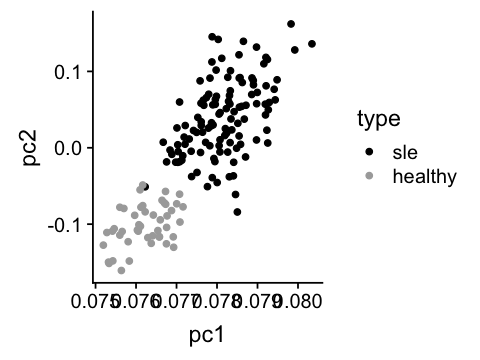

In [160]:

df <- rbind(data.frame(pc1=pbmc_expr_prcomp$rotation[sle_indices,1], pc2=pbmc_expr_prcomp$rotation[sle_indices,2], type="sle"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[healthy_indices,2], type="healthy"))

options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(aes(pc1,pc2,color=type),data=df)+geom_point()+scale_colour_manual(values=c("black","darkgray"))

## Load the raw counts from ```/ye/yelabstore2/10x.lupus/disease/demux.v2```

In [161]:
## either load only the original samples

# cm_counts <- fread("v2.deseq/norep.noadjrace.CD14+.Monocytes.counts.txt");
# colnames(cm_counts) <- sapply(colnames(cm_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# th_counts <- fread("v2.deseq/norep.noadjrace.CD4.T.cells.counts.txt");
# colnames(th_counts) <- sapply(colnames(th_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# tc_counts <- fread("v2.deseq/norep.noadjrace.CD8.T.cells.counts.txt");
# colnames(tc_counts) <- sapply(colnames(tc_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# ncm_counts <- fread("v2.deseq/norep.noadjrace.FCGR3A+.Monocytes.counts.txt");
# colnames(ncm_counts) <- sapply(colnames(ncm_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# b_counts <- fread("v2.deseq/norep.noadjrace.B.cells.counts.txt");
# colnames(b_counts) <- sapply(colnames(b_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# nk_counts <- fread("v2.deseq/norep.noadjrace.NK.cells.counts.txt");
# colnames(nk_counts) <- sapply(colnames(nk_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# dc_counts <- fread("v2.deseq/norep.noadjrace.Dendritic.cells.counts.txt");
# colnames(dc_counts) <- sapply(colnames(dc_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

# pbmc_counts <- fread("v2.deseq/norep.noadjrace.PBMC.counts.txt");
# colnames(pbmc_counts) <- sapply(colnames(pbmc_counts), function(x) {strsplit(x,"_")[[1]][[1]]})


## or new with immvar as separate

cm_counts <- fread("v2.deseq/fullimmvar.CD14+.Monocytes.counts.txt");
colnames(cm_counts) <- sapply(colnames(cm_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

th_counts <- fread("v2.deseq/fullimmvar.CD4.T.cells.counts.txt");
colnames(th_counts) <- sapply(colnames(th_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

tc_counts <- fread("v2.deseq/fullimmvar.CD8.T.cells.counts.txt");
colnames(tc_counts) <- sapply(colnames(tc_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

ncm_counts <- fread("v2.deseq/fullimmvar.FCGR3A+.Monocytes.counts.txt");
colnames(ncm_counts) <- sapply(colnames(ncm_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

b_counts <- fread("v2.deseq/fullimmvar.B.cells.counts.txt");
colnames(b_counts) <- sapply(colnames(b_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

nk_counts <- fread("v2.deseq/fullimmvar.NK.cells.counts.txt");
colnames(nk_counts) <- sapply(colnames(nk_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

dc_counts <- fread("v2.deseq/fullimmvar.Dendritic.cells.counts.txt");
colnames(dc_counts) <- sapply(colnames(dc_counts), function(x) {strsplit(x,"_")[[1]][[1]]})

pbmc_counts <- fread("v2.deseq/fullimmvar.PBMC.counts.txt");
colnames(pbmc_counts) <- sapply(colnames(pbmc_counts), function(x) {strsplit(x,"_")[[1]][[1]]})


counts_gene_names <- cm_counts$gene;
cm_counts <- as.matrix(cm_counts[,-1]);
pbmc_counts <- as.matrix(pbmc_counts[,-1]);
th_counts <- as.matrix(th_counts[,-1]);
tc_counts <- as.matrix(tc_counts[,-1]);
b_counts <- as.matrix(b_counts[,-1]);
ncm_counts <- as.matrix(ncm_counts[,-1]);
nk_counts <- as.matrix(nk_counts[,-1]);
dc_counts <- as.matrix(dc_counts[,-1]);

all_counts_samples <- na.omit(match(colnames(pbmc_expr), colnames(pbmc_counts)))

cm_counts <- cm_counts[,all_counts_samples]
pbmc_counts <- pbmc_counts[,all_counts_samples]
th_counts <- th_counts[,all_counts_samples]
tc_counts <- tc_counts[,all_counts_samples]
b_counts <- b_counts[,all_counts_samples]
ncm_counts <- ncm_counts[,all_counts_samples]
nk_counts <- nk_counts[,all_counts_samples]
dc_counts <- dc_counts[,all_counts_samples]

sle_counts_samples <- na.omit(match(sle_colnames, colnames(pbmc_counts)))

cm_sle_counts <- cm_counts[,sle_counts_samples]
th_sle_counts <- th_counts[,sle_counts_samples]
tc_sle_counts <- tc_counts[,sle_counts_samples]
ncm_sle_counts <- ncm_counts[,sle_counts_samples]
b_sle_counts <- b_counts[,sle_counts_samples]
nk_sle_counts <- nk_counts[,sle_counts_samples]
dc_sle_counts <- dc_counts[,sle_counts_samples]
pbmc_sle_counts <- pbmc_counts[,sle_counts_samples]


healthy_counts_samples <- na.omit(match(healthy_colnames, colnames(pbmc_counts)))

cm_healthy_counts <- cm_counts[,healthy_counts_samples]
th_healthy_counts <- th_counts[,healthy_counts_samples]
tc_healthy_counts <- tc_counts[,healthy_counts_samples]
ncm_healthy_counts <- ncm_counts[,healthy_counts_samples]
b_healthy_counts <- b_counts[,healthy_counts_samples]
nk_healthy_counts <- nk_counts[,healthy_counts_samples]
dc_healthy_counts <- dc_counts[,healthy_counts_samples]
pbmc_healthy_counts <- pbmc_counts[,healthy_counts_samples]



## Load the covariates from ```/ye/yelabstore2/10x.lupus/eqtls/demux.v2```

In [162]:
pbmc_covars <- as.data.frame(fread("v4.expr/v4.full.PBMC.covariates.txt"))[,-1];
cm_covars <- as.data.frame(fread("v4.expr/v4.full.CD14 Mono.covariates.txt"))[,-1];
th_covars <- as.data.frame(fread("v4.expr/v4.full.CD4+ T.covariates.txt"))[,-1];
tc_covars <- as.data.frame(fread("v4.expr/v4.full.CD8+ T.covariates.txt"))[,-1];
ncm_covars <- as.data.frame(fread("v4.expr/v4.full.CD16 Mono.covariates.txt"))[,-1];
b_covars <- as.data.frame(fread("v4.expr/v4.full.B.covariates.txt"))[,-1];
dc_covars <- as.data.frame(fread("v4.expr/v4.full.cDC.covariates.txt"))[,-1];

Warning message in fread("v4.expr/v4.full.PBMC.covariates.txt"):
“Detected 166 column names but the data has 167 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v4.expr/v4.full.CD14 Mono.covariates.txt"):
“Detected 166 column names but the data has 167 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v4.expr/v4.full.CD4+ T.covariates.txt"):
“Detected 166 column names but the data has 167 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. 

## Load the differentially expression results

In [163]:
pbmc_deseq <- fread("v2.deseq/norep.noadjrace.PBMC.deseq.txt")##as.data.frame()
th_deseq <- as.data.frame(fread("v2.deseq/norep.noadjrace.CD4.T.cells.deseq.txt"))
tc_deseq <- as.data.frame(fread("v2.deseq/norep.noadjrace.CD8.T.cells.deseq.txt"))
cm_deseq <- as.data.frame(fread("v2.deseq/norep.noadjrace.CD14+.Monocytes.deseq.txt"))
ncm_deseq <- as.data.frame(fread("v2.deseq/norep.noadjrace.FCGR3A+.Monocytes.deseq.txt"))
b_deseq <- as.data.frame(fread("v2.deseq/norep.noadjrace.B.cells.deseq.txt"))
nk_deseq <- as.data.frame(fread("v2.deseq/norep.noadjrace.NK.cells.deseq.txt"))
dc_deseq <- as.data.frame(fread("v2.deseq/norep.noadjrace.Dendritic.cells.deseq.txt"))

pbmc_deseq_sig <- as.data.frame(fread("v2.deseq/norep.noadjrace.PBMC.deseq.sig.txt",header=F))$V1
th_deseq_sig <- as.data.frame(fread("v2.deseq/norep.noadjrace.CD4.T.cells.deseq.sig.txt",header=F))$V1
tc_deseq_sig <- as.data.frame(fread("v2.deseq/norep.noadjrace.CD8.T.cells.deseq.sig.txt",header=F))$V1
cm_deseq_sig <- as.data.frame(fread("v2.deseq/norep.noadjrace.CD14+.Monocytes.deseq.sig.txt",header=F))$V1
ncm_deseq_sig <- as.data.frame(fread("v2.deseq/norep.noadjrace.FCGR3A+.Monocytes.deseq.sig.txt",header=F))$V1
b_deseq_sig <- as.data.frame(fread("v2.deseq/norep.noadjrace.B.cells.deseq.sig.txt",header=F))$V1
nk_deseq_sig <- as.data.frame(fread("v2.deseq/norep.noadjrace.NK.cells.deseq.sig.txt",header=F))$V1
dc_deseq_sig <- as.data.frame(fread("v2.deseq/norep.noadjrace.Dendritic.cells.deseq.sig.txt",header=F))$V1
union_deseq_sig <- unique(c(pbmc_deseq_sig, cm_deseq_sig, th_deseq_sig, tc_deseq_sig, b_deseq_sig, ncm_deseq_sig, nk_deseq_sig, dc_deseq_sig));

Warning message in fread("v2.deseq/norep.noadjrace.PBMC.deseq.txt"):
“Detected 7 column names but the data has 8 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v2.deseq/norep.noadjrace.CD4.T.cells.deseq.txt"):
“Detected 7 column names but the data has 8 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v2.deseq/norep.noadjrace.CD8.T.cells.deseq.txt"):
“Detected 7 column names but the data has 8 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an 

In [164]:
pbmc_deseq_sig_genes <- pbmc_deseq$V1[intersect(which(abs(pbmc_deseq$log2FoldChange)>1),which(pbmc_deseq$qval < 0.05))]
cm_deseq_sig_genes <- cm_deseq$V1[intersect(which(abs(cm_deseq$log2FoldChange)>1),which(cm_deseq$qval < 0.05))]
th_deseq_sig_genes <- th_deseq$V1[intersect(which(abs(th_deseq$log2FoldChange)>1),which(th_deseq$qval < 0.05))]
tc_deseq_sig_genes <- tc_deseq$V1[intersect(which(abs(tc_deseq$log2FoldChange)>1),which(tc_deseq$qval < 0.05))]
b_deseq_sig_genes <- b_deseq$V1[intersect(which(abs(b_deseq$log2FoldChange)>1),which(b_deseq$qval < 0.05))]
ncm_deseq_sig_genes <- ncm_deseq$V1[intersect(which(abs(ncm_deseq$log2FoldChange)>1),which(ncm_deseq$qval < 0.05))]
nk_deseq_sig_genes <- nk_deseq$V1[intersect(which(abs(nk_deseq$log2FoldChange)>1),which(nk_deseq$qval < 0.05))]
dc_deseq_sig_genes <- dc_deseq$V1[intersect(which(abs(dc_deseq$log2FoldChange)>1),which(dc_deseq$qval < 0.05))]

# union_deseq_sig_genes <- unique(c(pbmc_deseq_sig_genes, cm_deseq_sig_genes, ncm_deseq_sig_genes, dc_deseq_sig_genes, th_deseq_sig_genes, tc_deseq_sig_genes,  nk_deseq_sig_genes,b_deseq_sig_genes))
# union_deseq_sig_genes <- intersect(union_deseq_sig_genes, pbmc_deseq$V1[which(pbmc_deseq$baseMean>20)])
# length(union_deseq_sig_genes)
# length(pbmc_deseq_sig_genes)
# length(intersect(pbmc_deseq_sig_genes, union_deseq_sig_genes))
# union_deseq_sig_genes <- union_deseq_sig_genes[-grep("IGLL5",union_deseq_sig_genes)]

In [165]:
standardize <- function(x) {(x-mean(x))/sd(x)}

all_expr_standardize <- data.frame(pbmc=t(apply(pbmc_expr,1,standardize)),
                      cm=t(apply(cm_expr,1,standardize)),
                      ncm=t(apply(ncm_expr,1,standardize)),
                      dc=t(apply(dc_expr,1,standardize)),
                      th=t(apply(th_expr,1,standardize)),
                      tc=t(apply(tc_expr,1,standardize)),
                       nk=t(apply(nk_expr,1,standardize)),
                      b=t(apply(b_expr,1,standardize))
                      )


all_expr <- data.frame(pbmc=pbmc_expr,
                      cm=cm_expr,
                      ncm=ncm_expr,
                      dc=dc_expr,
                      th=th_expr,
                      tc=tc_expr,
                       nk=nk_expr,
                      b=b_expr
                      )

all_expr_sle <- data.frame(pbmc=pbmc_sle_expr,
                      cm=cm_sle_expr,
                      ncm=ncm_sle_expr,
                      dc=dc_sle_expr,
                      th=th_sle_expr,
                      tc=tc_sle_expr,
                       nk=nk_sle_expr,
                      b=b_sle_expr
                      )
rownames(all_expr_sle) <- rownames(all_expr)

all_expr_healthy <- data.frame(pbmc=pbmc_healthy_expr,
                      cm=cm_healthy_expr,
                      ncm=ncm_healthy_expr,
                      dc=dc_healthy_expr,
                      th=th_healthy_expr,
                      tc=tc_healthy_expr,
                       nk=nk_healthy_expr,
                      b=b_healthy_expr
                      )
rownames(all_expr_healthy) <- rownames(all_expr)



In [166]:
set.seed(1)
kmeans_rst <- kmeans(all_expr[match(pbmc_deseq_sig_genes,expr_gene_names),], 7)

cell_types <- c("PBMC","cM","ncM", "DC","Th","Tc","NK","B")
ct_annotation <- data.frame(type=factor(rep(cell_types,each=ncol(ncm_expr))),
                           disease=factor(rep(c(rep("sle",ncol(cm_sle_expr)),rep("ctrl",ncol(cm_healthy_expr))),length(cell_types))))
rownames(ct_annotation) <- colnames(all_expr);

kmeans_annotation <- data.frame(cluster=factor(kmeans_rst$cluster,levels=c("1","2","6","11","13","15","12","7","8","3","9","10","14","4","5")))
rownames(kmeans_annotation) <- pbmc_deseq_sig_genes;

all_expr_sig <- all_expr[match(pbmc_deseq_sig_genes,expr_gene_names),]
all_expr_sig_ordered <- all_expr[match(pbmc_deseq_sig_genes,expr_gene_names),][order(kmeans_annotation$cluster),]
kmeans_ordered_annotation <- kmeans_annotation[order(kmeans_annotation$cluster),]

all_expr_sle_sig <- all_expr_sle[match(pbmc_deseq_sig_genes,expr_gene_names),]
all_expr_sle_sig_ordered <- all_expr_sle[match(pbmc_deseq_sig_genes,expr_gene_names),][order(kmeans_annotation$cluster),]
##kmeans_ordered_annotation <- kmeans_annotation[order(kmeans_annotation$cluster),]


##bct_annotation <- list(ct_annotation=ct_annotation)

## Load the joined table and preprocess the expression and counts data

In [167]:
joined_pivot <- fread(paste(name,'_joined_pivot_ct_perc.txt', sep=""), sep=",")
joined_pivot <- as.data.frame(joined_pivot);
dim(joined_pivot)

[1] 166  20

# Figure 2A - heatmap

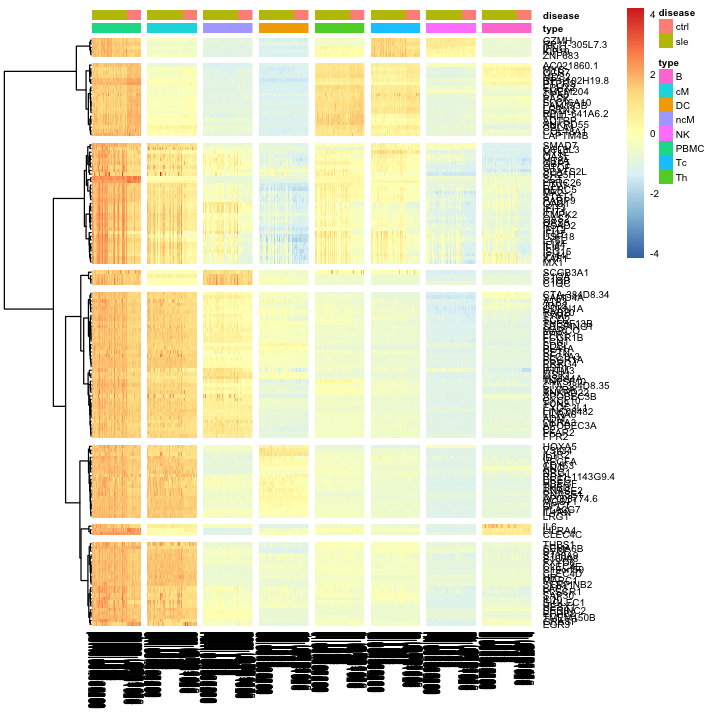

In [168]:
options(repr.plot.width = 6, repr.plot.height = 6)
pheatmap_out <- pheatmap(all_expr_sig,
         cluster_rows=T, cluster_cols=F, annotation_col = ct_annotation, #annotation_row = kmeans_annotation,
        gaps_col=seq(ncol(cm_expr),ncol(cm_expr)*length(cell_types),ncol(cm_expr)),cutree_rows=8, 
                         scale="row",fontsize=6,clustering_method="ward.D",clustering_distance_roww="manhattan")
options(repr.plot.width = 4, repr.plot.height = 4)

## More principled way to cut the tree and label the specific signatures

In [169]:
cuttree_out <- cutree(pheatmap_out$tree_row, k = 8)
cuttree_out[which(cuttree_out==4)] <- "dc_specific";
cuttree_out[which(cuttree_out==8)] <- "tc_specific";
cuttree_out[which(cuttree_out==1)] <- "th_specific";
cuttree_out[which(cuttree_out==7)] <- "all_ifn";
cuttree_out[which(cuttree_out==3)] <- "myeloid_ifn";
cuttree_out[which(cuttree_out==2)] <- "ncM_ifn";
cuttree_out[which(cuttree_out==6)] <- "cM_DC_ifn";
cuttree_out[which(cuttree_out==5)] <- "cM_ifn";

cuttree_out <- cbind(names(cuttree_out),cuttree_out)
colnames(cuttree_out) <- c("gene","cluster")
write.table(cuttree_out, file="diffexp.annotations.txt",sep="\t",col.names=T,row.names=F,quote=F);

# Figure 2B - correlogram to show coexpressed genes

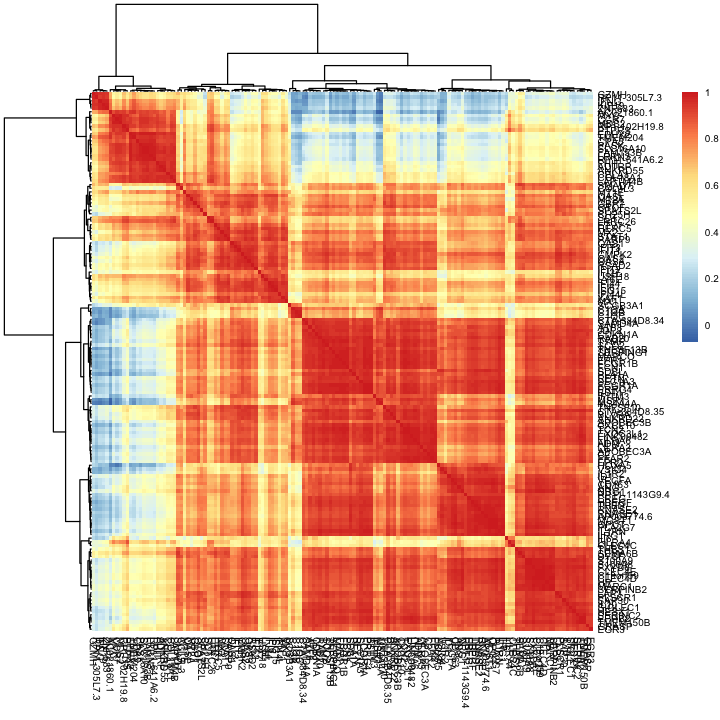

In [170]:
no_pbmc_cor <- cor(t(all_expr_sig[,-c(1,ncol(pbmc_expr))]))
options(repr.plot.width = 6, repr.plot.height = 6)
pheatmap(no_pbmc_cor,
         cluster_rows=pheatmap_out$tree_row, cluster_cols=pheatmap_out$tree_row, #annotation_row = kmeans_annotation,
         fontsize=6)
options(repr.plot.width = 4, repr.plot.height = 4)

# Figure 2C: Proportion of variance explained


In [171]:
joined_pivot_filtered <- joined_pivot[match(c(colnames(pbmc_sle_expr),colnames(pbmc_healthy_expr)),joined_pivot$ind_cov),]

cm_prop = joined_pivot_filtered$"CD14 Mo";##/joined_pivot_filtered$pbmc;
th_prop = joined_pivot_filtered$"CD4+ T";##/joined_pivot_filtered$pbmc;
b_prop = joined_pivot_filtered$"B";##/joined_pivot_filtered$pbmc;
nk_prop = joined_pivot_filtered$"NK";##/joined_pivot_filtered$pbmc;
ncm_prop = joined_pivot_filtered$"CD16 Mo";#/joined_pivot_filtered$pbmc;
tc_prop = joined_pivot_filtered$"CD8+ T";#/joined_pivot_filtered$pbmc;
dc_prop = joined_pivot_filtered$"cDC";#/joined_pivot_filtered$pbmc;

## set the NAs to 0
b_prop[which(is.na(b_prop))] <- 0;
dc_prop[which(is.na(dc_prop))] <- 0;

props <- cbind(cm_prop, th_prop, b_prop, nk_prop, ncm_prop, tc_prop, dc_prop)

cm_sle_prop = cm_prop[match(colnames(pbmc_sle_expr), joined_pivot_filtered$ind_cov)]
th_sle_prop = th_prop[match(colnames(pbmc_sle_expr), joined_pivot_filtered$ind_cov)]
b_sle_prop = b_prop[match(colnames(pbmc_sle_expr), joined_pivot_filtered$ind_cov)]
nk_sle_prop = nk_prop[match(colnames(pbmc_sle_expr), joined_pivot_filtered$ind_cov)]
ncm_sle_prop = ncm_prop[match(colnames(pbmc_sle_expr), joined_pivot_filtered$ind_cov)]
tc_sle_prop = tc_prop[match(colnames(pbmc_sle_expr), joined_pivot_filtered$ind_cov)]
dc_sle_prop = dc_prop[match(colnames(pbmc_sle_expr), joined_pivot_filtered$ind_cov)]

sle_props <- cbind(cm_sle_prop, th_sle_prop, b_sle_prop, nk_sle_prop, ncm_sle_prop, tc_sle_prop, dc_sle_prop)

cm_healthy_prop = cm_prop[match(colnames(pbmc_healthy_expr), joined_pivot_filtered$ind_cov)]
th_healthy_prop = th_prop[match(colnames(pbmc_healthy_expr), joined_pivot_filtered$ind_cov)]
b_healthy_prop = b_prop[match(colnames(pbmc_healthy_expr), joined_pivot_filtered$ind_cov)]
nk_healthy_prop = nk_prop[match(colnames(pbmc_healthy_expr), joined_pivot_filtered$ind_cov)]
ncm_healthy_prop = ncm_prop[match(colnames(pbmc_healthy_expr), joined_pivot_filtered$ind_cov)]
tc_healthy_prop = tc_prop[match(colnames(pbmc_healthy_expr), joined_pivot_filtered$ind_cov)]
dc_healthy_prop = dc_prop[match(colnames(pbmc_healthy_expr), joined_pivot_filtered$ind_cov)]

healthy_props <- cbind(cm_healthy_prop, th_healthy_prop, b_healthy_prop, nk_healthy_prop, ncm_healthy_prop, tc_healthy_prop, dc_healthy_prop)

First, we are going to estimate proportion of variance explained by cell type proportion

This will be a multiple regression

\begin{equation*}
e_i = -1 + b_1\times p_1 + b_2\times p_2 + ... + b_n\times p_n
\end{equation*}

Next, we are going to estimate proportion of variance explained by cell type specific expression

This will be a multiple regression


\begin{equation*}
e_i = -1 + b_1\times e_1 + b_2\times e_2 + ... + b_n\times e_n
\end{equation*}

calculate adjusted r_2 and also the cell type specific r2

Y_i = %mono*mono_i + %other*other_i + err
Or
Y_i = %mono*mono_i
log(Y_i) = log(%mono)+log(mono_i)+err


## Processing all - now, let's fit with -1 but we need to standardize the outcome

In [172]:
dim(pbmc_expr)

[1] 11088   166

In [173]:
# ## including dc analysis
# pbmc_expr_std <- t(apply(pbmc_expr,1,standardize))
# cm_expr_std <- t(apply(cm_expr,1,standardize))
# th_expr_std <- t(apply(th_expr,1,standardize))
# b_expr_std <- t(apply(b_expr,1,standardize))
# nk_expr_std <- t(apply(nk_expr,1,standardize))
# ncm_expr_std <- t(apply(ncm_expr,1,standardize))
# tc_expr_std <- t(apply(tc_expr,1,standardize))
# dc_expr_std <- t(apply(dc_expr,1,standardize))


# output_prop_noint <- NULL;

# ## -1 so that the ordering doesn't matter

# for(i in 1:nrow(pbmc_expr_std)) {
#     model <- lm(pbmc_expr_std[i,]~cm_prop+th_prop+b_prop+nk_prop+ncm_prop+tc_prop+dc_prop-1)
#     ##model_anova <- anova(model)
#     ##sum_sq <- model_anova$"Sum Sq"
#     r2 = summary(model)$coef[,1]^2*apply(cbind(cm_prop,th_prop,b_prop,nk_prop,ncm_prop,tc_prop,dc_prop), 2,var,na.rm=T)/var(pbmc_expr_std[i,])*100;
#     output_prop_noint <- rbind(output_prop_noint, 
#                                c(r2,
#                                sum(r2),
#                                summary(model)$adj.r.squared*100))
# }

# rownames(output_prop_noint) <- expr_gene_names;
# colnames(output_prop_noint) <- c("cM","Th","B","NK","ncM","Tc","DC","total r2","adj r2")

# output_expr_noint <- NULL;

# ## -1 so that the ordering doesn't matter

# for(i in 1:nrow(pbmc_expr_std)) {
#     model <- lm(pbmc_expr_std[i,]~th_expr_std[i,]+cm_expr_std[i,]+b_expr_std[i,]+nk_expr_std[i,]+ncm_expr_std[i,]+tc_expr_std[i,]+dc_expr_std[i,]-1)
    
#     r2 = summary(model)$coef[,1]^2*apply(cbind(cm_expr_std[i,],th_expr_std[i,],b_expr_std[i,],nk_expr_std[i,],ncm_expr_std[i,],tc_expr_std[i,],dc_expr_std[i,]), 2,var,na.rm=T)/var(pbmc_expr_std[i,])*100;
    
#     output_expr_noint <- rbind(output_expr_noint, 
#                                c(r2,
#                                sum(r2),
#                                summary(model)$adj.r.squared*100))
# }

# rownames(output_expr_noint) <- expr_gene_names;
# colnames(output_expr_noint) <- c("cM","Th","B","NK","ncM","Tc","DC","total r2","adj r2")

## no dc analysis
pbmc_expr_std <- t(apply(pbmc_expr,1,standardize))
cm_expr_std <- t(apply(cm_expr,1,standardize))
th_expr_std <- t(apply(th_expr,1,standardize))
b_expr_std <- t(apply(b_expr,1,standardize))
nk_expr_std <- t(apply(nk_expr,1,standardize))
ncm_expr_std <- t(apply(ncm_expr,1,standardize))
tc_expr_std <- t(apply(tc_expr,1,standardize))
dc_expr_std <- t(apply(dc_expr,1,standardize))


output_prop_noint <- NULL;

## -1 so that the ordering doesn't matter

for(i in 1:nrow(pbmc_expr_std)) {
    model <- lm(pbmc_expr_std[i,]~cm_prop+th_prop+b_prop+nk_prop+ncm_prop+tc_prop-1)
    ##model_anova <- anova(model)
    ##sum_sq <- model_anova$"Sum Sq"
    r2 = summary(model)$coef[,1]^2*apply(cbind(cm_prop,th_prop,b_prop,nk_prop,ncm_prop,tc_prop), 2,var,na.rm=T)/var(pbmc_expr_std[i,])*100;
    output_prop_noint <- rbind(output_prop_noint, 
                               c(r2,
                               sum(r2),
                               summary(model)$adj.r.squared*100))
}

rownames(output_prop_noint) <- expr_gene_names;
colnames(output_prop_noint) <- c("cM","Th","B","NK","ncM","Tc","total r2","adj r2")

output_expr_noint <- NULL;

## -1 so that the ordering doesn't matter

for(i in 1:nrow(pbmc_expr_std)) {
    model <- lm(pbmc_expr_std[i,]~th_expr_std[i,]+cm_expr_std[i,]+b_expr_std[i,]+nk_expr_std[i,]+ncm_expr_std[i,]+tc_expr_std[i,]-1)
    
    r2 = summary(model)$coef[,1]^2*apply(cbind(cm_expr_std[i,],th_expr_std[i,],b_expr_std[i,],nk_expr_std[i,],ncm_expr_std[i,],tc_expr_std[i,]), 2,var,na.rm=T)/var(pbmc_expr_std[i,])*100;
    
    output_expr_noint <- rbind(output_expr_noint, 
                               c(r2,
                               sum(r2),
                               summary(model)$adj.r.squared*100))
}

rownames(output_expr_noint) <- expr_gene_names;
colnames(output_expr_noint) <- c("cM","Th","B","NK","ncM","Tc","total r2","adj r2")

## adjust out the batch effect

## Processing SLE

### All of SLE

In [177]:
# ## including dc analysis
# pbmc_sle_expr_std <- t(apply(pbmc_sle_expr,1,standardize))
# cm_sle_expr_std <- t(apply(cm_sle_expr,1,standardize))
# th_sle_expr_std <- t(apply(th_sle_expr,1,standardize))
# b_sle_expr_std <- t(apply(b_sle_expr,1,standardize))
# nk_sle_expr_std <- t(apply(nk_sle_expr,1,standardize))
# ncm_sle_expr_std <- t(apply(ncm_sle_expr,1,standardize))
# tc_sle_expr_std <- t(apply(tc_sle_expr,1,standardize))
# dc_sle_expr_std <- t(apply(dc_sle_expr,1,standardize))

# output_sle_prop_noint <- NULL;

# ## -1 so that the ordering doesn't matter

# for(i in 1:nrow(pbmc_sle_expr_std)) {
#     model <- lm(pbmc_sle_expr_std[i,]~cm_sle_prop+th_sle_prop+b_sle_prop+nk_sle_prop+ncm_sle_prop+tc_sle_prop+dc_sle_prop-1)
#     ##model_anova <- anova(model)
#     ##sum_sq <- model_anova$"Sum Sq"
#     r2 = summary(model)$coef[,1]^2*apply(cbind(cm_sle_prop,th_sle_prop,b_sle_prop,nk_sle_prop,ncm_sle_prop,tc_sle_prop,dc_sle_prop), 2,var,na.rm=T)/var(pbmc_sle_expr_std[i,])*100;
#     output_sle_prop_noint <- rbind(output_sle_prop_noint, 
#                                c(r2,
#                                sum(r2),
#                                summary(model)$adj.r.squared*100))
# }

# rownames(output_sle_prop_noint) <- expr_gene_names;
# colnames(output_sle_prop_noint) <- c("cM","Th","B","NK","ncM","Tc","DC","total r2","adj r2")

# output_sle_expr_noint <- NULL;

# ## -1 so that the ordering doesn't matter

# for(i in 1:nrow(pbmc_sle_expr_std)) {
#     model <- lm(pbmc_sle_expr_std[i,]~th_sle_expr_std[i,]+cm_sle_expr_std[i,]+b_sle_expr_std[i,]+nk_sle_expr_std[i,]+ncm_sle_expr_std[i,]+tc_sle_expr_std[i,]+dc_sle_expr_std[i,]-1)
    
#     r2 = summary(model)$coef[,1]^2*apply(cbind(cm_sle_expr_std[i,],th_sle_expr_std[i,],b_sle_expr_std[i,],nk_sle_expr_std[i,],ncm_sle_expr_std[i,],tc_sle_expr_std[i,],dc_sle_expr_std[i,]), 2,var,na.rm=T)/var(pbmc_sle_expr_std[i,])*100;
    
#     output_sle_expr_noint <- rbind(output_sle_expr_noint, 
#                                c(r2,
#                                sum(r2),
#                                summary(model)$adj.r.squared*100))
# }

# rownames(output_sle_expr_noint) <- expr_gene_names;
# colnames(output_sle_expr_noint) <- c("cM","Th","B","NK","ncM","Tc","DC","total r2","adj r2")


## no dc analysis
pbmc_sle_expr_std <- t(apply(pbmc_sle_expr,1,standardize))
cm_sle_expr_std <- t(apply(cm_sle_expr,1,standardize))
th_sle_expr_std <- t(apply(th_sle_expr,1,standardize))
b_sle_expr_std <- t(apply(b_sle_expr,1,standardize))
nk_sle_expr_std <- t(apply(nk_sle_expr,1,standardize))
ncm_sle_expr_std <- t(apply(ncm_sle_expr,1,standardize))
tc_sle_expr_std <- t(apply(tc_sle_expr,1,standardize))
dc_sle_expr_std <- t(apply(dc_sle_expr,1,standardize))

output_sle_prop_noint <- NULL;

## -1 so that the ordering doesn't matter

for(i in 1:nrow(pbmc_sle_expr_std)) {
    model <- lm(pbmc_sle_expr_std[i,]~cm_sle_prop+th_sle_prop+b_sle_prop+nk_sle_prop+ncm_sle_prop+tc_sle_prop-1)
    ##model_anova <- anova(model)
    ##sum_sq <- model_anova$"Sum Sq"
    r2 = summary(model)$coef[,1]^2*apply(cbind(cm_sle_prop,th_sle_prop,b_sle_prop,nk_sle_prop,ncm_sle_prop,tc_sle_prop), 2,var,na.rm=T)/var(pbmc_sle_expr_std[i,])*100;
    output_sle_prop_noint <- rbind(output_sle_prop_noint, 
                               c(r2,
                               sum(r2),
                               summary(model)$adj.r.squared*100))
}

rownames(output_sle_prop_noint) <- expr_gene_names;
colnames(output_sle_prop_noint) <- c("cM","Th","B","NK","ncM","Tc","total r2","adj r2")

output_sle_expr_noint <- NULL;

## -1 so that the ordering doesn't matter

for(i in 1:nrow(pbmc_sle_expr_std)) {
    model <- lm(pbmc_sle_expr_std[i,]~th_sle_expr_std[i,]+cm_sle_expr_std[i,]+b_sle_expr_std[i,]+nk_sle_expr_std[i,]+ncm_sle_expr_std[i,]+tc_sle_expr_std[i,]-1)
    
    r2 = summary(model)$coef[,1]^2*apply(cbind(cm_sle_expr_std[i,],th_sle_expr_std[i,],b_sle_expr_std[i,],nk_sle_expr_std[i,],ncm_sle_expr_std[i,],tc_sle_expr_std[i,]), 2,var,na.rm=T)/var(pbmc_sle_expr_std[i,])*100;
    
    output_sle_expr_noint <- rbind(output_sle_expr_noint, 
                               c(r2,
                               sum(r2),
                               summary(model)$adj.r.squared*100))
}

rownames(output_sle_expr_noint) <- expr_gene_names;
colnames(output_sle_expr_noint) <- c("cM","Th","B","NK","ncM","Tc","total r2","adj r2")

[1] 0.4905098

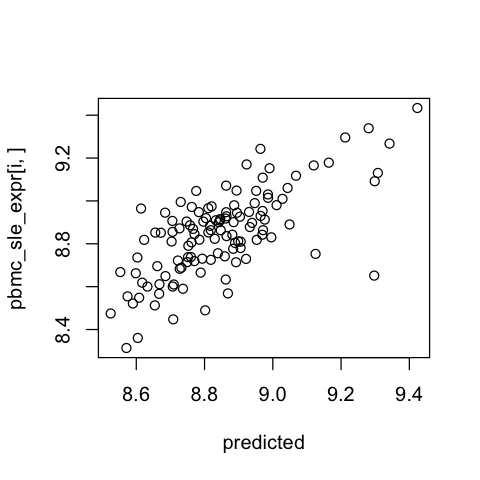

[1] 0.2342989

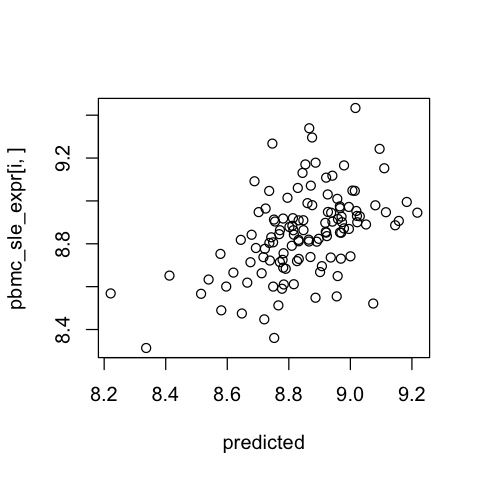

[1] 0.8394286

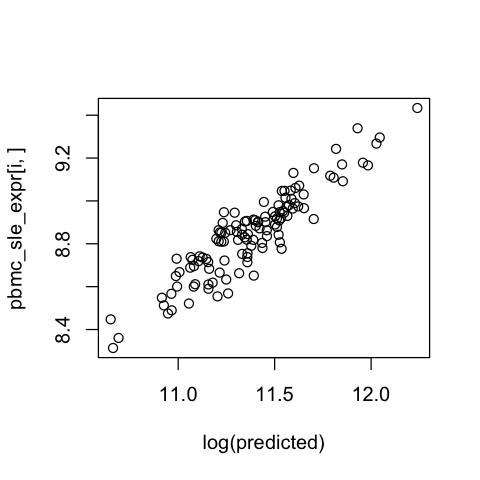

In [178]:
options(repr.plot.width = 4, repr.plot.height = 4)
i=2
i=grep("^CD4$",expr_gene_names)[1]

model <- lm(pbmc_sle_expr[i,]~cm_sle_prop+th_sle_prop+b_sle_prop+nk_sle_prop+ncm_sle_prop+tc_sle_prop-1)
predicted <- model$fitted
plot(predicted, pbmc_sle_expr[i,])
cor(predicted, pbmc_sle_expr[i,])^2

model <- lm(pbmc_sle_expr[i,]~th_sle_expr[i,]+cm_sle_expr[i,]+b_sle_expr[i,]+nk_sle_expr[i,]+ncm_sle_expr[i,]+tc_sle_expr[i,]-1)
predicted <- model$fitted
plot(predicted, pbmc_sle_expr[i,])
cor(predicted, pbmc_sle_expr[i,])^2

predicted <- exp(th_sle_expr[i,])*th_sle_prop+exp(cm_sle_expr[i,])*cm_sle_prop+exp(b_sle_expr[i,])*b_sle_prop+
            exp(nk_sle_expr[i,])*nk_sle_prop+exp(ncm_sle_expr[i,])*ncm_sle_prop+exp(tc_sle_expr[i,])*tc_sle_prop
plot(log(predicted), pbmc_sle_expr[i,])
cor(log(predicted), pbmc_sle_expr[i,])^2


[1] 0.8726553

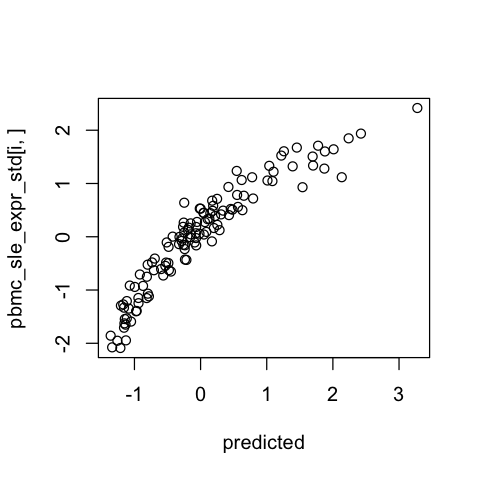

[1] 0.4553363

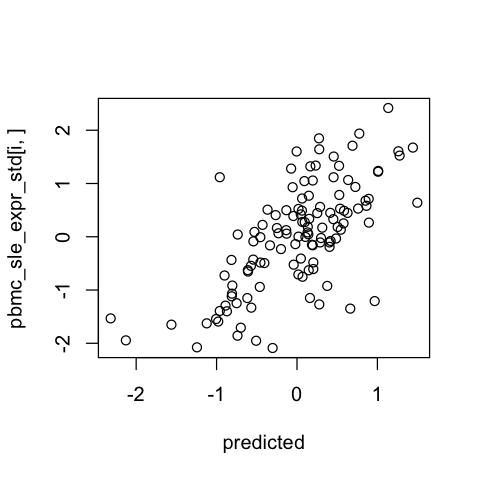

[1] 0.9755699

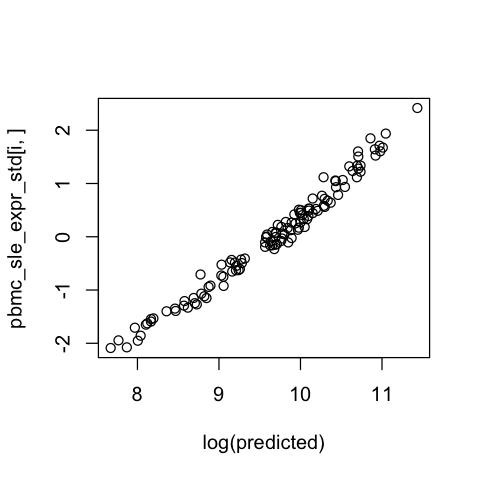

In [179]:
options(repr.plot.width = 4, repr.plot.height = 4)
i=2
i=grep("^CD22$",expr_gene_names)[1]

model <- lm(pbmc_sle_expr_std[i,]~cm_sle_prop+th_sle_prop+b_sle_prop+nk_sle_prop+ncm_sle_prop+tc_sle_prop-1)
predicted <- model$fitted
plot(predicted, pbmc_sle_expr_std[i,])
cor(predicted, pbmc_sle_expr_std[i,])^2

model <- lm(pbmc_sle_expr_std[i,]~th_sle_expr_std[i,]+cm_sle_expr_std[i,]+b_sle_expr_std[i,]+nk_sle_expr_std[i,]+ncm_sle_expr_std[i,]
            +tc_sle_expr_std[i,]-1)
predicted <- model$fitted
plot(predicted, pbmc_sle_expr_std[i,])
cor(predicted, pbmc_sle_expr_std[i,])^2

predicted <- exp(th_sle_expr[i,])*th_sle_prop+exp(cm_sle_expr[i,])*cm_sle_prop+exp(b_sle_expr[i,])*b_sle_prop+
            exp(nk_sle_expr[i,])*nk_sle_prop+exp(ncm_sle_expr[i,])*ncm_sle_prop+exp(tc_sle_expr[i,])*tc_sle_prop
plot(log(predicted), pbmc_sle_expr_std[i,])
cor(log(predicted), pbmc_sle_expr_std[i,])^2


### Downsampled SLE to 46 samples

In [180]:
# ## including dc analysis
# N <- 46;
# samples <- sample(1:length(cm_sle_prop), N)

# output_sle_down_prop_noint <- NULL;

# ## -1 so that the ordering doesn't matter

# for(i in 1:nrow(pbmc_sle_expr_std)) {
#     model <- lm(pbmc_sle_expr_std[i,samples]~cm_sle_prop[samples]+th_sle_prop[samples]+b_sle_prop[samples]+nk_sle_prop[samples]+ncm_sle_prop[samples]+tc_sle_prop[samples]+dc_sle_prop[samples]-1)
#     ##model_anova <- anova(model)
#     ##sum_sq <- model_anova$"Sum Sq"
#     r2 = summary(model)$coef[,1]^2*apply(cbind(cm_sle_prop[samples],th_sle_prop[samples],b_sle_prop[samples],nk_sle_prop[samples],ncm_sle_prop[samples],tc_sle_prop[samples],dc_sle_prop[samples]), 2,var,na.rm=T)/var(pbmc_sle_expr_std[i,samples])*100;
#     output_sle_down_prop_noint <- rbind(output_sle_down_prop_noint, 
#                                c(r2,
#                                sum(r2),
#                                summary(model)$adj.r.squared*100))
# }

# rownames(output_sle_down_prop_noint) <- expr_gene_names;
# colnames(output_sle_down_prop_noint) <- c("cM","Th","B","NK","ncM","Tc","DC","total r2","adj r2")

# output_sle_down_expr_noint <- NULL;

# ## -1 so that the ordering doesn't matter

# for(i in 1:nrow(pbmc_sle_expr_std)) {
#     model <- lm(pbmc_sle_expr_std[i,samples]~th_sle_expr_std[i,samples]+cm_sle_expr_std[i,samples]+b_sle_expr_std[i,samples]+nk_sle_expr_std[i,samples]+ncm_sle_expr_std[i,samples]+tc_sle_expr_std[i,samples]+dc_sle_expr_std[i,samples]-1)
    
#     r2 = summary(model)$coef[,1]^2*apply(cbind(cm_sle_expr_std[i,samples],th_sle_expr_std[i,samples],b_sle_expr_std[i,samples],nk_sle_expr_std[i,samples],ncm_sle_expr_std[i,samples],tc_sle_expr_std[i,samples],dc_sle_expr_std[i,samples]), 2,var,na.rm=T)/var(pbmc_sle_expr_std[i,samples])*100;
    
#     output_sle_down_expr_noint <- rbind(output_sle_down_expr_noint, 
#                                c(r2,
#                                sum(r2),
#                                summary(model)$adj.r.squared*100))
# }

# rownames(output_sle_down_expr_noint) <- expr_gene_names;
# colnames(output_sle_down_expr_noint) <- c("cM","Th","B","NK","ncM","Tc","DC","total r2","adj r2")


## no dc analysis

N <- 46;
samples <- sample(1:length(cm_sle_prop), N)

output_sle_down_prop_noint <- NULL;

## -1 so that the ordering doesn't matter

for(i in 1:nrow(pbmc_sle_expr_std)) {
    model <- lm(pbmc_sle_expr_std[i,samples]~cm_sle_prop[samples]+th_sle_prop[samples]+b_sle_prop[samples]+nk_sle_prop[samples]+ncm_sle_prop[samples]+tc_sle_prop[samples]-1)
    ##model_anova <- anova(model)
    ##sum_sq <- model_anova$"Sum Sq"
    r2 = summary(model)$coef[,1]^2*apply(cbind(cm_sle_prop[samples],th_sle_prop[samples],b_sle_prop[samples],nk_sle_prop[samples],ncm_sle_prop[samples],tc_sle_prop[samples]), 2,var,na.rm=T)/var(pbmc_sle_expr_std[i,samples])*100;
    output_sle_down_prop_noint <- rbind(output_sle_down_prop_noint, 
                               c(r2,
                               sum(r2),
                               summary(model)$adj.r.squared*100))
}

rownames(output_sle_down_prop_noint) <- expr_gene_names;
colnames(output_sle_down_prop_noint) <- c("cM","Th","B","NK","ncM","Tc","total r2","adj r2")

output_sle_down_expr_noint <- NULL;

## -1 so that the ordering doesn't matter

for(i in 1:nrow(pbmc_sle_expr_std)) {
    model <- lm(pbmc_sle_expr_std[i,samples]~th_sle_expr_std[i,samples]+cm_sle_expr_std[i,samples]+b_sle_expr_std[i,samples]+nk_sle_expr_std[i,samples]+ncm_sle_expr_std[i,samples]+tc_sle_expr_std[i,samples]-1)
    
    r2 = summary(model)$coef[,1]^2*apply(cbind(cm_sle_expr_std[i,samples],th_sle_expr_std[i,samples],b_sle_expr_std[i,samples],nk_sle_expr_std[i,samples],ncm_sle_expr_std[i,samples],tc_sle_expr_std[i,samples]), 2,var,na.rm=T)/var(pbmc_sle_expr_std[i,samples])*100;
    
    output_sle_down_expr_noint <- rbind(output_sle_down_expr_noint, 
                               c(r2,
                               sum(r2),
                               summary(model)$adj.r.squared*100))
}

rownames(output_sle_down_expr_noint) <- expr_gene_names;
colnames(output_sle_down_expr_noint) <- c("cM","Th","B","NK","ncM","Tc","total r2","adj r2")

## Processing healthy

In [181]:
# ## including dc analysis
# pbmc_healthy_expr_std <- t(apply(pbmc_healthy_expr,1,standardize))
# cm_healthy_expr_std <- t(apply(cm_healthy_expr,1,standardize))
# cm_healthy_expr_std[is.na(cm_healthy_expr_std)] <- 0
# th_healthy_expr_std <- t(apply(th_healthy_expr,1,standardize))
# th_healthy_expr_std[is.na(th_healthy_expr_std)] <- 0
# b_healthy_expr_std <- t(apply(b_healthy_expr,1,standardize))
# b_healthy_expr_std[is.na(b_healthy_expr_std)] <- 0
# nk_healthy_expr_std <- t(apply(nk_healthy_expr,1,standardize))
# nk_healthy_expr_std[is.na(nk_healthy_expr_std)] <- 0
# ncm_healthy_expr_std <- t(apply(ncm_healthy_expr,1,standardize))
# ncm_healthy_expr_std[is.na(ncm_healthy_expr_std)] <- 0
# tc_healthy_expr_std <- t(apply(tc_healthy_expr,1,standardize))
# tc_healthy_expr_std[is.na(tc_healthy_expr_std)] <- 0
# dc_healthy_expr_std <- t(apply(dc_healthy_expr,1,standardize))
# dc_healthy_expr_std[is.na(dc_healthy_expr_std)] <- 0

# output_healthy_prop_noint <- NULL;

# ## -1 so that the ordering doesn't matter

# for(i in 1:nrow(pbmc_healthy_expr_std)) {
#     model <- lm(pbmc_healthy_expr_std[i,]~cm_healthy_prop+th_healthy_prop+b_healthy_prop+nk_healthy_prop+ncm_healthy_prop+tc_healthy_prop+dc_healthy_prop-1)
#     ##model_anova <- anova(model)
#     ##sum_sq <- model_anova$"Sum Sq"
#     r2 = summary(model)$coef[,1]^2*apply(cbind(cm_healthy_prop,th_healthy_prop,b_healthy_prop,nk_healthy_prop,ncm_healthy_prop,tc_healthy_prop,dc_healthy_prop), 2,var,na.rm=T)/var(pbmc_healthy_expr_std[i,])*100;
#     output_healthy_prop_noint <- rbind(output_healthy_prop_noint, 
#                                c(r2,
#                                sum(r2),
#                                summary(model)$adj.r.squared*100))
# }

# rownames(output_healthy_prop_noint) <- expr_gene_names;
# colnames(output_healthy_prop_noint) <- c("cM","Th","B","NK","ncM","Tc","DC","total r2","adj r2")

# output_healthy_expr_noint <- NULL;

# ## -1 so that the ordering doesn't matter

# for(i in 1:nrow(pbmc_healthy_expr_std)) {
#     model <- lm(pbmc_healthy_expr_std[i,]~th_healthy_expr_std[i,]+cm_healthy_expr_std[i,]+b_healthy_expr_std[i,]+nk_healthy_expr_std[i,]+ncm_healthy_expr_std[i,]+tc_healthy_expr_std[i,]+dc_healthy_expr_std[i,]-1)
    
#     r2 = summary(model)$coef[,1]^2*apply(cbind(cm_healthy_expr_std[i,],th_healthy_expr_std[i,],b_healthy_expr_std[i,],nk_healthy_expr_std[i,],ncm_healthy_expr_std[i,],tc_healthy_expr_std[i,],dc_healthy_expr_std[i,]), 2,var,na.rm=T)/var(pbmc_healthy_expr_std[i,])*100;
    
#     output_healthy_expr_noint <- rbind(output_healthy_expr_noint, 
#                                c(r2,
#                                sum(r2,na.rm=T),
#                                summary(model)$adj.r.squared*100))
# }

# rownames(output_healthy_expr_noint) <- expr_gene_names;
# colnames(output_healthy_expr_noint) <- c("cM","Th","B","NK","ncM","Tc","DC","total r2","adj r2")

## no dc analysis
pbmc_healthy_expr_std <- t(apply(pbmc_healthy_expr,1,standardize))
cm_healthy_expr_std <- t(apply(cm_healthy_expr,1,standardize))
cm_healthy_expr_std[is.na(cm_healthy_expr_std)] <- 0
th_healthy_expr_std <- t(apply(th_healthy_expr,1,standardize))
th_healthy_expr_std[is.na(th_healthy_expr_std)] <- 0
b_healthy_expr_std <- t(apply(b_healthy_expr,1,standardize))
b_healthy_expr_std[is.na(b_healthy_expr_std)] <- 0
nk_healthy_expr_std <- t(apply(nk_healthy_expr,1,standardize))
nk_healthy_expr_std[is.na(nk_healthy_expr_std)] <- 0
ncm_healthy_expr_std <- t(apply(ncm_healthy_expr,1,standardize))
ncm_healthy_expr_std[is.na(ncm_healthy_expr_std)] <- 0
tc_healthy_expr_std <- t(apply(tc_healthy_expr,1,standardize))
tc_healthy_expr_std[is.na(tc_healthy_expr_std)] <- 0
dc_healthy_expr_std <- t(apply(dc_healthy_expr,1,standardize))
dc_healthy_expr_std[is.na(dc_healthy_expr_std)] <- 0

output_healthy_prop_noint <- NULL;

## -1 so that the ordering doesn't matter

for(i in 1:nrow(pbmc_healthy_expr_std)) {
    model <- lm(pbmc_healthy_expr_std[i,]~cm_healthy_prop+th_healthy_prop+b_healthy_prop+nk_healthy_prop+ncm_healthy_prop+tc_healthy_prop-1)
    ##model_anova <- anova(model)
    ##sum_sq <- model_anova$"Sum Sq"
    r2 = summary(model)$coef[,1]^2*apply(cbind(cm_healthy_prop,th_healthy_prop,b_healthy_prop,nk_healthy_prop,ncm_healthy_prop,tc_healthy_prop), 2,var,na.rm=T)/var(pbmc_healthy_expr_std[i,])*100;
    output_healthy_prop_noint <- rbind(output_healthy_prop_noint, 
                               c(r2,
                               sum(r2),
                               summary(model)$adj.r.squared*100))
}

rownames(output_healthy_prop_noint) <- expr_gene_names;
colnames(output_healthy_prop_noint) <- c("cM","Th","B","NK","ncM","Tc","total r2","adj r2")

output_healthy_expr_noint <- NULL;

## -1 so that the ordering doesn't matter

for(i in 1:nrow(pbmc_healthy_expr_std)) {
    model <- lm(pbmc_healthy_expr_std[i,]~th_healthy_expr_std[i,]+cm_healthy_expr_std[i,]+b_healthy_expr_std[i,]+nk_healthy_expr_std[i,]+ncm_healthy_expr_std[i,]+tc_healthy_expr_std[i,]-1)
    
    r2 = summary(model)$coef[,1]^2*apply(cbind(cm_healthy_expr_std[i,],th_healthy_expr_std[i,],b_healthy_expr_std[i,],nk_healthy_expr_std[i,],ncm_healthy_expr_std[i,],tc_healthy_expr_std[i,]), 2,var,na.rm=T)/var(pbmc_healthy_expr_std[i,])*100;
    
    output_healthy_expr_noint <- rbind(output_healthy_expr_noint, 
                               c(r2,
                               sum(r2,na.rm=T),
                               summary(model)$adj.r.squared*100))
}

rownames(output_healthy_expr_noint) <- expr_gene_names;
colnames(output_healthy_expr_noint) <- c("cM","Th","B","NK","ncM","Tc","total r2","adj r2")

## Summarize and plotting results

In [182]:
# all_ifn_indices <- match(cuttree_out[,"gene"][which(cuttree_out[,"cluster"]=="all_ifn")], rownames(output_expr))
# myeloid_ifn_indices <- match(cuttree_out[,"gene"][which(cuttree_out[,"cluster"]=="myeloid_ifn")],rownames(output_expr))
# ncm_ifn_indices <- match(cuttree_out[,"gene"][which(cuttree_out[,"cluster"]=="ncM_ifn")],rownames(output_expr))

cor        prop_mean expr_mean sum_mean 
all_noint      -0.6382174 21.00394  78.99593   99.99987
sle_noint      -0.7344679 20.13005  77.19966   97.32971
sle_down_noint -0.5336652 20.23492  79.03329   99.26820
healthy_noint  -0.5138207 17.17524  83.14209  100.31733

cM        Th        B        NK       ncM      Tc       
all_noint_prop       6.550037  4.059750 2.290141 1.390288 1.700561  1.198287
all_noint_expr       9.864590 15.752106 3.738308 1.982496 2.224216  8.899064
sle_noint_prop       5.587880  4.005919 3.003618 2.122952 2.148751  1.839134
sle_noint_expr       9.162077 17.686458 3.967223 2.126500 2.640276  8.876581
sle_down_noint_prop  6.219733  4.455861 3.757274 3.851493 3.381788  4.715944
sle_down_noint_expr 10.589246 20.825452 4.324331 2.843942 3.073081  8.895177
healthy_noint_prop   6.233008  3.173706 5.153048 4.153889 2.959187  1.731355
healthy_noint_expr  16.212910 11.827618 5.890492 3.232771 2.794772 11.384022
                    total.r2 adj.r2  
all_noint_prop      17.18906 21.00394
all_noint_expr      42.46078 78.99593
sle_noint_prop      18.70825 20.13005
sle_noint_expr      44.45912 77.19966
sle_down_noint_prop 26.38209 20.23492
sle_down_noint_expr 50.55123 79.03329
healthy_noint_prop  23.40419 17.17524
healthy_noint_expr  51.34258 83.14209

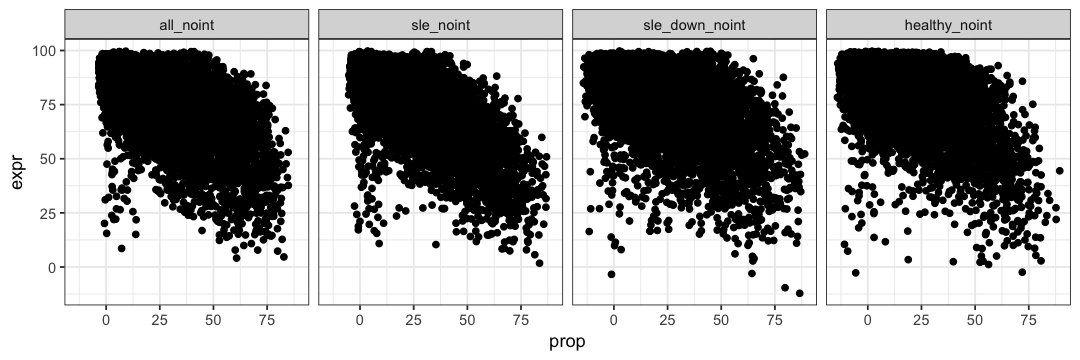

In [183]:
output_noint_df <- data.frame(prop=output_prop_noint[,"adj r2"], expr=output_expr_noint[,"adj r2"], type="all_noint")
output_sle_noint_df <- data.frame(prop=output_sle_prop_noint[,"adj r2"], expr=output_sle_expr_noint[,"adj r2"], type="sle_noint")
output_sle_down_noint_df <- data.frame(prop=output_sle_down_prop_noint[,"adj r2"], expr=output_sle_down_expr_noint[,"adj r2"], type="sle_down_noint")
output_healthy_noint_df <- data.frame(prop=output_healthy_prop_noint[,"adj r2"], expr=output_healthy_expr_noint[,"adj r2"], type="healthy_noint")

df <- rbind(output_noint_df, output_sle_noint_df, output_sle_down_noint_df, output_healthy_noint_df)

options(repr.plot.width = 9, repr.plot.height = 3)
ggplot(aes(prop, expr), data=df)+geom_point()+facet_grid(~type)+theme_bw()

df2 <- data.frame(cor=c(cor(output_prop_noint[,"adj r2"], output_expr_noint[,"adj r2"]), cor(output_sle_prop_noint[,"adj r2"], output_sle_expr_noint[,"adj r2"]), cor(output_sle_down_prop_noint[,"adj r2"], output_sle_down_expr_noint[,"adj r2"]), cor(output_healthy_prop_noint[,"adj r2"], output_healthy_expr_noint[,"adj r2"])),
      prop_mean=c(mean(output_prop_noint[,"adj r2"]), mean(output_sle_prop_noint[,"adj r2"]), mean(output_sle_down_prop_noint[,"adj r2"]), mean(output_healthy_prop_noint[,"adj r2"])),
      expr_mean=c(mean(output_expr_noint[,"adj r2"]), mean(output_sle_expr_noint[,"adj r2"]), mean(output_sle_down_expr_noint[,"adj r2"]), mean(output_healthy_expr_noint[,"adj r2"])),
      sum_mean = c(mean(output_prop_noint[,"adj r2"]+output_expr_noint[,"adj r2"]), mean(output_sle_prop_noint[,"adj r2"]+output_sle_expr_noint[,"adj r2"]), mean(output_sle_down_prop_noint[,"adj r2"]+output_sle_down_expr_noint[,"adj r2"]), mean(output_healthy_prop_noint[,"adj r2"]+output_healthy_expr_noint[,"adj r2"])))
rownames(df2) <- c("all_noint", "sle_noint", "sle_down_noint", "healthy_noint")

df2

df3 <- rbind(data.frame(t(apply(output_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_expr_noint,2,mean,na.rm=T))),
             data.frame(t(apply(output_sle_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_expr_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_down_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_down_expr_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_healthy_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_healthy_expr_noint,2,mean,na.rm=T))))

rownames(df3) <- c("all_noint_prop", "all_noint_expr", "sle_noint_prop", "sle_noint_expr", "sle_down_noint_prop", "sle_down_noint_expr", "healthy_noint_prop", "healthy_noint_expr")

df3

In [184]:
r2 <- cbind(output_sle_down_prop_noint[,"adj r2"],output_healthy_prop_noint[,"adj r2"])
r2[order(apply(r2,1,mean),decreasing=T),]

[,1]       [,2]      
BANK1         85.91009   87.75478  
FAM129C       85.94962   87.66318  
EBF1          85.80333   83.41626  
TIMP2         86.91507   80.69705  
CD22          87.50727   78.22258  
PAX5          87.06838   76.89562  
GNG7          86.56003   74.75735  
MS4A1         83.39101   77.75529  
LST1          85.55759   74.74836  
LINC00926     79.14998   80.43352  
H2AFY         75.15192   83.92987  
KIAA0226L     82.12122   74.79668  
RALGPS2       85.10698   71.74110  
WDFY3         75.74289   80.74496  
AFF3          86.14118   69.80750  
CD79A         83.27601   71.95958  
CYBB          75.69038   78.30536  
LPCAT2        77.78559   76.08851  
CTSS          74.68681   79.04765  
CDKN1C        64.23539   89.42071  
TCF7L2        74.26365   78.70858  
STRBP         82.86013   69.86134  
CLIC3         74.44182   77.96135  
FCRL1         86.40956   65.73658  
MS4A6A        74.36664   77.61730  
PLEKHG1       81.83736   70.12153  
BLVRB         81.38491   69.99329  
CTA-250D10.23 82.46793   68.78448  
DMXL2         70.48922   80.70997  
FGL2          80.42283   70.57562  
⋮             ⋮          ⋮         
ZNF282         -6.944273  -8.971067
MINK1          -4.410313 -11.508390
DGCR14         -4.662986 -11.315433
USP19          -9.233039  -6.804642
DBP            -8.008315  -8.130127
ZNF440        -11.778351  -4.477946
TARS2         -10.435775  -5.837343
F8A1           -8.750843  -7.839066
RP11-69E11.4   -6.869439  -9.797972
PAXIP1         -9.629049  -7.042028
CUL9          -10.178832  -6.777409
ESYT2         -10.714471  -6.579546
COG7           -6.919100 -10.446409
IVD            -7.583366  -9.792749
RNF185        -11.952502  -5.438048
LINC00852      -5.405486 -12.734503
ST20           -6.440556 -12.013990
NCOA5          -8.270776 -10.514016
CAMKK1         -8.762304 -10.166688
NUDT2         -11.587364  -7.958973
XPOT           -9.971211  -9.669944
IFT122        -10.221321  -9.663638
GLYCTK         -9.514210 -10.376996
TMEM86B        -6.514245 -13.481711
PSKH1         -11.769135  -8.513423
FBXO8         -10.739826  -9.611940
ARID3B        -11.815038  -8.586637
C11orf68      -11.150925 -10.543521
NFYA          -12.256278 -10.366268
ACSF3          -9.595712 -13.286198

In [185]:
r2.rat <- cbind(output_sle_down_prop_noint[,"total r2"]/(output_sle_down_expr_noint[,"total r2"]+output_sle_down_prop_noint[,"total r2"]),
                output_healthy_prop_noint[,"total r2"]/(output_healthy_expr_noint[,"total r2"]+output_healthy_prop_noint[,"total r2"]))
r2.rat["NKG7",]

[1] 0.4323267 0.5562631

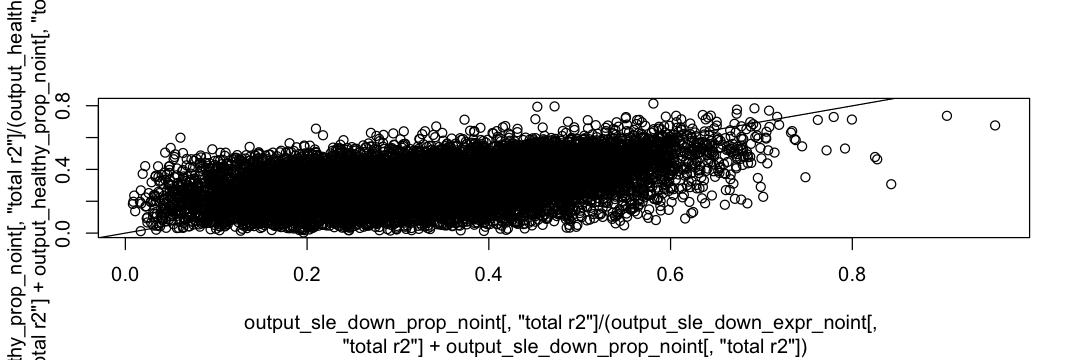

In [186]:
## look for cell type proportion genes
plot(output_sle_down_prop_noint[,"total r2"]/(output_sle_down_expr_noint[,"total r2"]+output_sle_down_prop_noint[,"total r2"]),
output_healthy_prop_noint[,"total r2"]/(output_healthy_expr_noint[,"total r2"]+output_healthy_prop_noint[,"total r2"]))
abline(a=0,b=1)


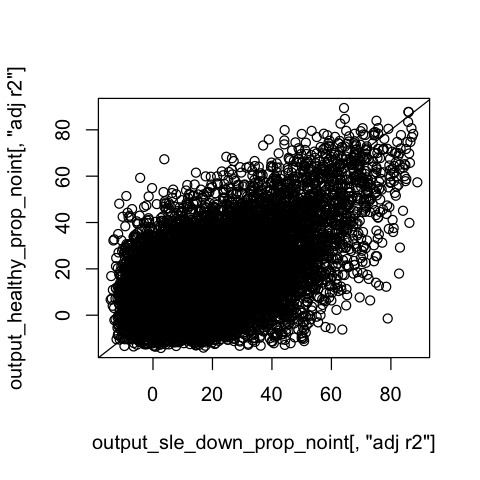

In [187]:
options(repr.plot.width = 4, repr.plot.height = 4)
plot(output_sle_down_prop_noint[,"adj r2"], output_healthy_prop_noint[,"adj r2"])
abline(b=1,a=0)

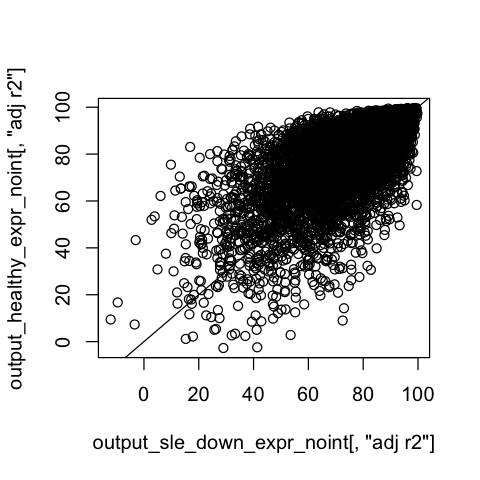

In [188]:
options(repr.plot.width = 4, repr.plot.height = 4)
plot(output_sle_down_expr_noint[,"adj r2"], output_healthy_expr_noint[,"adj r2"])
abline(b=1,a=0)

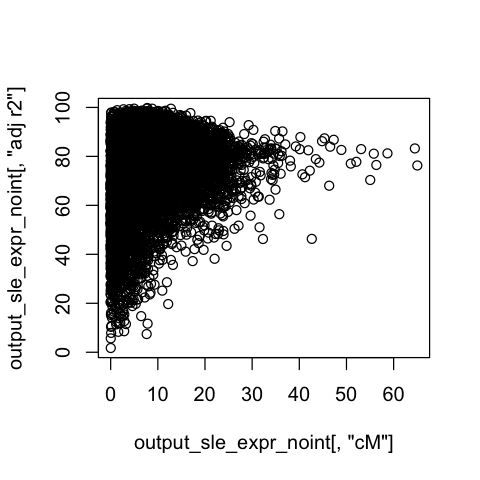

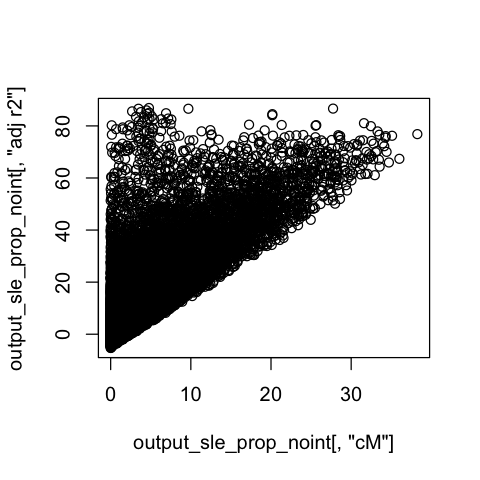

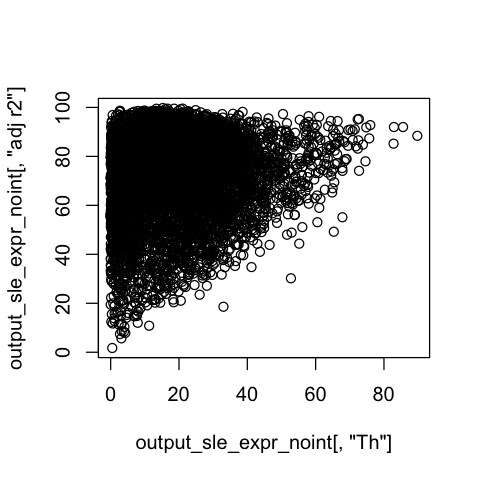

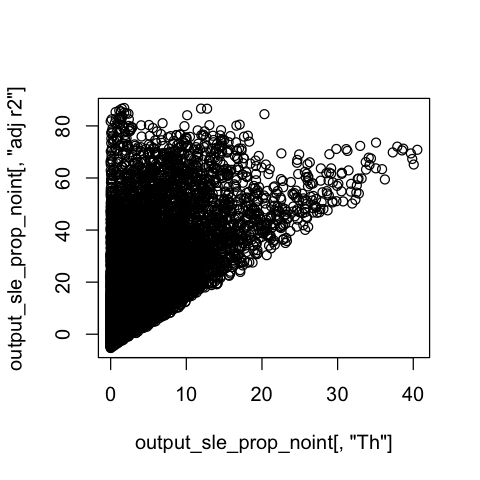

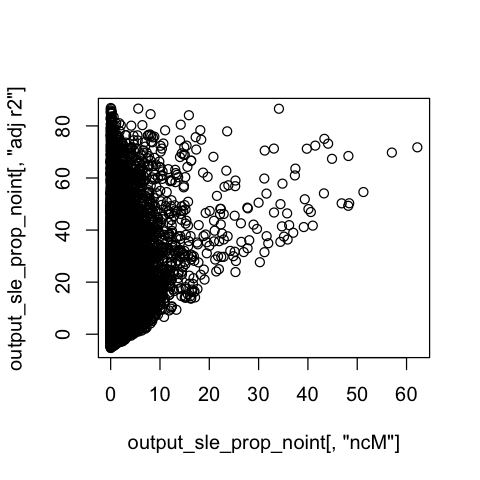

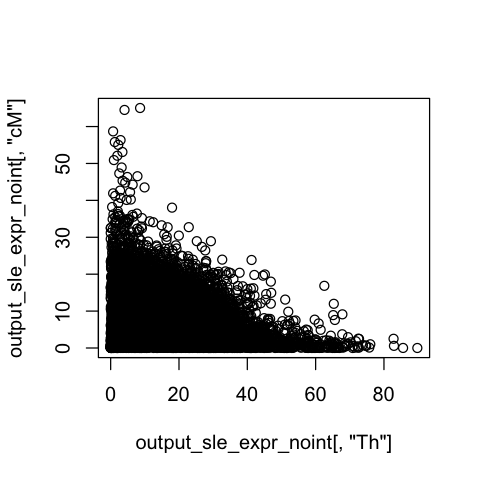

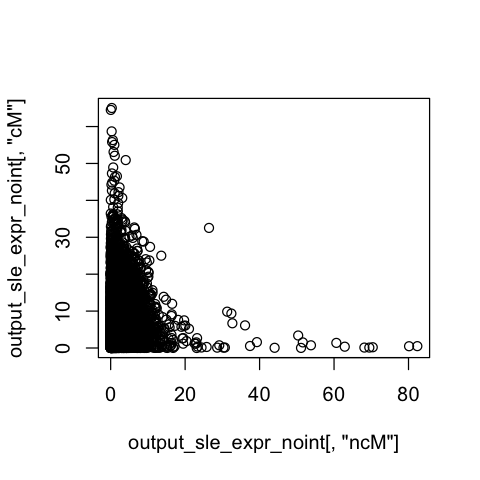

In [189]:
options(repr.plot.width = 4, repr.plot.height = 4)
plot(output_sle_expr_noint[,"cM"], output_sle_expr_noint[,"adj r2"])
plot(output_sle_prop_noint[,"cM"], output_sle_prop_noint[,"adj r2"])
plot(output_sle_expr_noint[,"Th"], output_sle_expr_noint[,"adj r2"])
plot(output_sle_prop_noint[,"Th"], output_sle_prop_noint[,"adj r2"])
plot(output_sle_prop_noint[,"ncM"], output_sle_prop_noint[,"adj r2"])
plot(output_sle_expr_noint[,"Th"], output_sle_expr_noint[,"cM"])
plot(output_sle_expr_noint[,"ncM"], output_sle_expr_noint[,"cM"])


# Let's do the estimation using resampling

We are going to work with counts here. Given the expression of an arbitrary gene $i$ and individual $j$ in PBMCs $P$, and two cell types (B and T) for simplicity. $N_j^B$ and $N_j^T$ are the number of B cells and T cells for individual $j$.

\begin{align*}
P_{ij} &= B_{ij1}+B_{ij2}+...+B_{ijN_b}+T_{ij1}+T_{ij2}+...+T_{ijN_t} \\
P_{ij} &= \sum_k^{N_j^B}B_{ijk} + \sum_k^{N_j^T}T_{ijk} \\
P_{ij} &= N_j^B\times{\bar{B}_{ij}} + N_j^T\times{\bar{T}_{ij}} \\
\bar{P_{ij}} &= {{N_j^B}\over{N_j^{PBMC}}}\times{\bar{B_{ij}}} + {{N_j^T}\over{N_j^{PBMC}}}\times{\bar{T_{ij}}} \\
\bar{P_{ij}} &= {{{\rho}_j^B}\times{\bar{B_{ij}}} + {{\rho}_j^T}\times{\bar{T_{ij}}}}
\end{align*}


$\bar{B}_{ij}$ is the average expression of the gene $i$ in individual $j$ in cell type B. $\bar{T}_{ij}$ is the average expression of the gene $i$ in individual $j$ in cell type T

First, fit proportion

\begin{align*}
\bar{P_{ij}} &= {{\rho}_j^B}\times{\bar{B_{i}}} + {{\rho}_j^T}\times{\bar{T_{i}}}
\end{align*}

When we fit, we will take the average of expression over all individuals. That is $\bar{B_{i}} = {{\sum_j^{J}\bar{B_{ij}}}\over{J}}$

Second, fit expression

\begin{align*}
\bar{P_{ij}} &= {\bar{{\rho}^B}}\times{B_{ij}} + {\bar{{\rho}^T}}\times{T_{ij}}
\end{align*}

When we fit, we will take the average of expression over all individuals. That is $\bar{{\rho}^B} = {{{\sum_j^{J}{\rho_j^B}}}\over{J}}$


## First, let's do all individuals

In [190]:
# joined_pivot_filtered <- joined_pivot[match(colnames(pbmc_counts),joined_pivot$ind_cov),]

# cm_prop = joined_pivot_filtered$"CD14 Mo";##/joined_pivot_filtered$pbmc;
# th_prop = joined_pivot_filtered$"CD4+ T";##/joined_pivot_filtered$pbmc;
# b_prop = joined_pivot_filtered$"B";##/joined_pivot_filtered$pbmc;
# nk_prop = joined_pivot_filtered$"NK";##/joined_pivot_filtered$pbmc;
# ncm_prop = joined_pivot_filtered$"CD16 Mo";#/joined_pivot_filtered$pbmc;
# tc_prop = joined_pivot_filtered$"CD8+ T";#/joined_pivot_filtered$pbmc;
# dc_prop = joined_pivot_filtered$"cDC";#/joined_pivot_filtered$pbmc;

# props <- cbind(cm_prop, th_prop, b_prop, nk_prop, ncm_prop, tc_prop, dc_prop)

# cm_sle_prop = cm_prop[match(colnames(pbmc_sle_counts), joined_pivot_filtered$ind_cov)]
# th_sle_prop = th_prop[match(colnames(pbmc_sle_counts), joined_pivot_filtered$ind_cov)]
# b_sle_prop = b_prop[match(colnames(pbmc_sle_counts), joined_pivot_filtered$ind_cov)]
# nk_sle_prop = nk_prop[match(colnames(pbmc_sle_counts), joined_pivot_filtered$ind_cov)]
# ncm_sle_prop = ncm_prop[match(colnames(pbmc_sle_counts), joined_pivot_filtered$ind_cov)]
# tc_sle_prop = tc_prop[match(colnames(pbmc_sle_counts), joined_pivot_filtered$ind_cov)]
# dc_sle_prop = dc_prop[match(colnames(pbmc_sle_counts), joined_pivot_filtered$ind_cov)]

# sle_props <- cbind(cm_sle_prop, th_sle_prop, b_sle_prop, nk_sle_prop, ncm_sle_prop, tc_sle_prop, dc_sle_prop)

# cm_healthy_prop = cm_prop[match(colnames(pbmc_healthy_counts), joined_pivot_filtered$ind_cov)]
# th_healthy_prop = th_prop[match(colnames(pbmc_healthy_counts), joined_pivot_filtered$ind_cov)]
# b_healthy_prop = b_prop[match(colnames(pbmc_healthy_counts), joined_pivot_filtered$ind_cov)]
# nk_healthy_prop = nk_prop[match(colnames(pbmc_healthy_counts), joined_pivot_filtered$ind_cov)]
# ncm_healthy_prop = ncm_prop[match(colnames(pbmc_healthy_counts), joined_pivot_filtered$ind_cov)]
# tc_healthy_prop = tc_prop[match(colnames(pbmc_healthy_counts), joined_pivot_filtered$ind_cov)]
# dc_healthy_prop = dc_prop[match(colnames(pbmc_healthy_counts), joined_pivot_filtered$ind_cov)]

# healthy_props <- cbind(cm_healthy_prop, th_healthy_prop, b_healthy_prop, nk_healthy_prop, ncm_healthy_prop, tc_healthy_prop, dc_healthy_prop)


In [191]:
joined_pivot_filtered <- joined_pivot[match(colnames(pbmc_expr),joined_pivot$ind_cov),]

# cm_counts_mean <- sweep(exp(cm_expr), 2, joined_pivot_filtered$counts*cm_prop/100, "/")
# th_counts_mean <- sweep(exp(th_expr), 2, joined_pivot_filtered$counts*th_prop/100, "/")
# tc_counts_mean <- sweep(exp(tc_expr), 2, joined_pivot_filtered$counts*tc_prop/100, "/")
# b_counts_mean <- sweep(exp(b_expr), 2, joined_pivot_filtered$counts*b_prop/100, "/")
# nk_counts_mean <- sweep(exp(nk_expr), 2, joined_pivot_filtered$counts*nk_prop/100, "/")
# ncm_counts_mean <- sweep(exp(ncm_expr), 2, joined_pivot_filtered$counts*ncm_prop/100, "/")
# dc_counts_mean <- sweep(exp(dc_expr), 2, joined_pivot_filtered$counts*dc_prop/100, "/")
# pbmc_counts_mean <- sweep(exp(pbmc_expr), 2, joined_pivot_filtered$counts, "/")

cm_counts_mean <- exp(cm_expr)
th_counts_mean <- exp(th_expr)
tc_counts_mean <- exp(tc_expr)
b_counts_mean <- exp(b_expr)
nk_counts_mean <- exp(nk_expr)
ncm_counts_mean <- exp(ncm_expr)
dc_counts_mean <- exp(dc_expr)
pbmc_counts_mean <- exp(pbmc_expr)

## some samples do not have b cells or dcs, let's set those means to 0
b_counts_mean[is.nan(b_counts_mean)] <- 0;
dc_counts_mean[is.nan(dc_counts_mean)] <- 0;
b_counts_mean[!is.finite(b_counts_mean)] <- 0;
dc_counts_mean[!is.finite(dc_counts_mean)] <- 0;

# cm_counts_global_mean <- rowSums(exp(cm_expr))/sum(joined_pivot_filtered$counts*cm_prop/100, na.rm=T)
# th_counts_global_mean <- rowSums(exp(th_expr))/sum(joined_pivot_filtered$counts*th_prop/100, na.rm=T)
# tc_counts_global_mean <- rowSums(exp(tc_expr))/sum(joined_pivot_filtered$counts*tc_prop/100, na.rm=T)
# b_counts_global_mean <- rowSums(exp(b_expr))/sum(joined_pivot_filtered$counts*b_prop/100, na.rm=T)
# nk_counts_global_mean <- rowSums(exp(nk_expr))/sum(joined_pivot_filtered$counts*nk_prop/100, na.rm=T)
# ncm_counts_global_mean <- rowSums(exp(ncm_expr))/sum(joined_pivot_filtered$counts*ncm_prop/100, na.rm=T)
# dc_counts_global_mean <- rowSums(exp(dc_expr))/sum(joined_pivot_filtered$counts*dc_prop/100, na.rm=T)

cm_counts_global_mean <- apply(exp(cm_expr),1,mean)
th_counts_global_mean <- apply(exp(th_expr),1,mean)
tc_counts_global_mean <- apply(exp(tc_expr),1,mean)
b_counts_global_mean <- apply(exp(b_expr),1,mean)
nk_counts_global_mean <- apply(exp(nk_expr),1,mean)
ncm_counts_global_mean <- apply(exp(ncm_expr),1,mean)
dc_counts_global_mean <- apply(exp(dc_expr),1,mean)


a <- cbind(cm_counts_global_mean, th_counts_global_mean, tc_counts_global_mean, b_counts_global_mean, nk_counts_global_mean, ncm_counts_global_mean, dc_counts_global_mean)
##sle_counts_means <- cbind(cm_sle_counts_mean, th_sle_counts_mean, tc_sle_counts_mean, b_sle_counts_mean, nk_sle_counts_mean, ncm_sle_counts_mean, dc_sle_counts_mean)

output_direct_global_prop <- NULL;

for(i in 1:nrow(pbmc_counts[match(expr_gene_names, counts_gene_names),])) {    
    predicted <- rowSums(cbind(cm_counts_global_mean[i]*cm_prop/100,
                               th_counts_global_mean[i]*th_prop/100, 
                               b_counts_global_mean[i]*b_prop/100, 
                               nk_counts_global_mean[i]*nk_prop/100, 
                               ncm_counts_global_mean[i]*ncm_prop/100, 
                               tc_counts_global_mean[i]*tc_prop/100), na.rm=T)
##                               dc_counts_global_mean[i]*dc_prop/100), na.rm=T)

    output_direct_global_prop <- rbind(output_direct_global_prop, c(cor(log(predicted),pbmc_expr_std[i,])^2*100, 1-cor(log(predicted),pbmc_expr_std[i,])^2*100))
}


rownames(output_direct_global_prop) <- counts_gene_names[match(expr_gene_names, counts_gene_names)];
colnames(output_direct_global_prop) <- c("r2", "res")

output_direct_global_expr <- NULL;

cm_prop_global_mean <- sum(joined_pivot_filtered$counts*cm_prop/100,na.rm=T)/sum(joined_pivot_filtered$counts)
th_prop_global_mean <- sum(joined_pivot_filtered$counts*th_prop/100,na.rm=T)/sum(joined_pivot_filtered$counts)
tc_prop_global_mean <- sum(joined_pivot_filtered$counts*tc_prop/100,na.rm=T)/sum(joined_pivot_filtered$counts)
b_prop_global_mean <- sum(joined_pivot_filtered$counts*b_prop/100,na.rm=T)/sum(joined_pivot_filtered$counts)
nk_prop_global_mean <- sum(joined_pivot_filtered$counts*nk_prop/100,na.rm=T)/sum(joined_pivot_filtered$counts)
ncm_prop_global_mean <- sum(joined_pivot_filtered$counts*ncm_prop/100,na.rm=T)/sum(joined_pivot_filtered$counts)
dc_prop_global_mean <- sum(joined_pivot_filtered$counts*dc_prop/100,na.rm=T)/sum(joined_pivot_filtered$counts)

a_prop <- c(cm_prop_global_mean, th_prop_global_mean, tc_prop_global_mean, b_prop_global_mean, nk_prop_global_mean, ncm_prop_global_mean, dc_prop_global_mean);

for(i in 1:nrow(pbmc_counts[match(expr_gene_names, counts_gene_names),])) {
   predicted <- rowSums(cbind(cm_counts_mean[i,]*cm_prop_global_mean, 
                              th_counts_mean[i,]*th_prop_global_mean, 
                              b_counts_mean[i,]*b_prop_global_mean,
                              nk_counts_mean[i,]*nk_prop_global_mean, 
                               ncm_counts_mean[i,]*ncm_prop_global_mean,
                              tc_counts_mean[i,]*tc_prop_global_mean), na.rm=T)
##                              dc_counts_mean[i,]*dc_prop_global_mean), na.rm=T)

    output_direct_global_expr <- rbind(output_direct_global_expr, c(cor(log(predicted),pbmc_expr_std[i,])^2*100, 1-cor(log(predicted),pbmc_expr_std[i,])^2*100))
}

rownames(output_direct_global_expr) <- expr_gene_names;
colnames(output_direct_global_expr) <- c("r2", "res")

[1] 0.921466

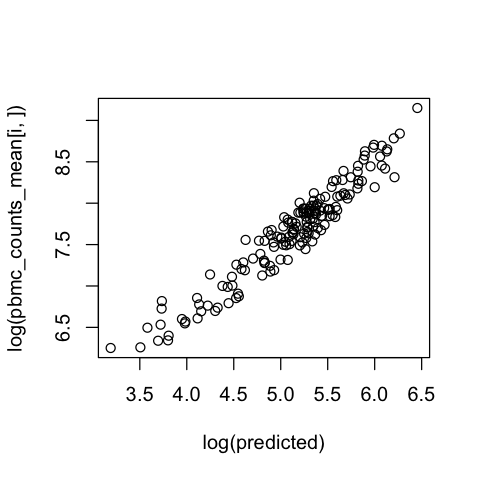

[1] 0.4139134

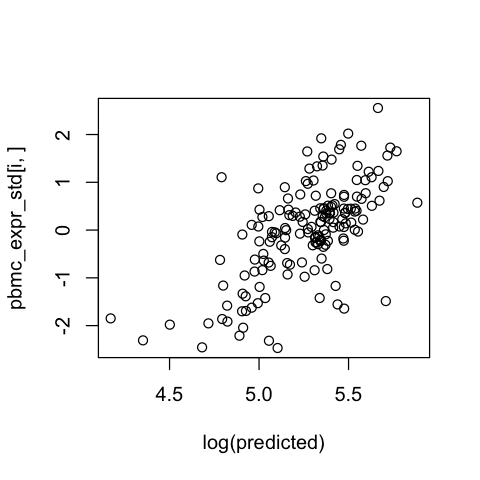

[1] 0.9678966

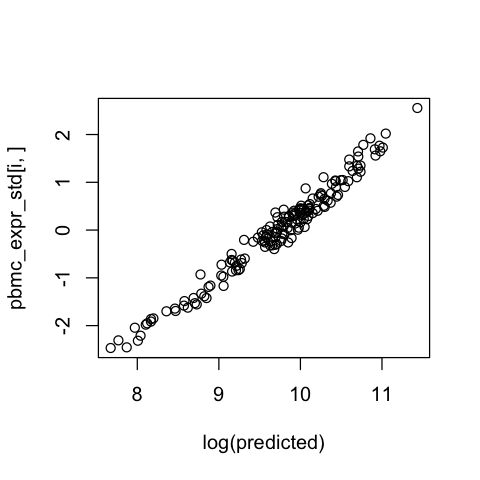

In [192]:
options(repr.plot.width = 4, repr.plot.height = 4)
i=10
i=grep("^CD22$",expr_gene_names)[1]
##i=grep("ERAP2",expr_gene_names)[1]
predicted <- rowSums(cbind(cm_counts_global_mean[i]*cm_prop/100,
                               th_counts_global_mean[i]*th_prop/100,
                               b_counts_global_mean[i]*b_prop/100,
                               nk_counts_global_mean[i]*nk_prop/100, 
                               ncm_counts_global_mean[i]*ncm_prop/100,
                               tc_counts_global_mean[i]*tc_prop/100), na.rm=T)
plot(log(predicted), log(pbmc_counts_mean[i,]))
cor(log(predicted), pbmc_expr_std[i,])^2

predicted <- rowSums(cbind(cm_counts_mean[i,]*cm_prop_global_mean, 
                              th_counts_mean[i,]*th_prop_global_mean, 
                              b_counts_mean[i,]*b_prop_global_mean,
                              nk_counts_mean[i,]*nk_prop_global_mean, 
                               ncm_counts_mean[i,]*ncm_prop_global_mean,
                              tc_counts_mean[i,]*tc_prop_global_mean,
                          dc_counts_mean[i,]*dc_prop_global_mean), na.rm=T)
plot(log(predicted), pbmc_expr_std[i,])
cor(log(predicted), pbmc_expr_std[i,])^2


predicted <- rowSums(cbind(cm_counts_mean[i,]*cm_prop, 
                              th_counts_mean[i,]*th_prop, 
                              b_counts_mean[i,]*b_prop,
                              nk_counts_mean[i,]*nk_prop, 
                               ncm_counts_mean[i,]*ncm_prop,
                              tc_counts_mean[i,]*tc_prop,
                          dc_counts_mean[i,]*dc_prop), na.rm=T)
plot(log(predicted), pbmc_expr_std[i,])
cor(log(predicted), pbmc_expr_std[i,])^2

## Second, let's do SLE

Mean of means might be a bit unstable, let's calculate a global mean

### All SLE

In [193]:
joined_pivot_sle <- joined_pivot[match(colnames(pbmc_sle_expr), joined_pivot$ind_cov),]

# cm_sle_counts_mean <- sweep(exp(cm_sle_expr), 2, joined_pivot_sle$counts*cm_sle_prop/100, "/")
# th_sle_counts_mean <- sweep(exp(th_sle_expr), 2, joined_pivot_sle$counts*th_sle_prop/100, "/")
# tc_sle_counts_mean <- sweep(exp(tc_sle_expr), 2, joined_pivot_sle$counts*tc_sle_prop/100, "/")
# b_sle_counts_mean <- sweep(exp(b_sle_expr), 2, joined_pivot_sle$counts*b_sle_prop/100, "/")
# nk_sle_counts_mean <- sweep(exp(nk_sle_expr), 2, joined_pivot_sle$counts*nk_sle_prop/100, "/")
# ncm_sle_counts_mean <- sweep(exp(ncm_sle_expr), 2, joined_pivot_sle$counts*ncm_sle_prop/100, "/")
# dc_sle_counts_mean <- sweep(exp(dc_sle_expr), 2, joined_pivot_sle$counts*dc_sle_prop/100, "/")
# pbmc_sle_counts_mean <- sweep(exp(pbmc_sle_expr), 2, joined_pivot_sle$counts, "/")


cm_sle_counts_mean <- exp(cm_sle_expr);
th_sle_counts_mean <- exp(th_sle_expr);
tc_sle_counts_mean <- exp(tc_sle_expr);
b_sle_counts_mean <- exp(b_sle_expr);
nk_sle_counts_mean <- exp(nk_sle_expr);
ncm_sle_counts_mean <- exp(ncm_sle_expr);
dc_sle_counts_mean <- exp(dc_sle_expr);
pbmc_sle_counts_mean <- exp(pbmc_sle_expr);

# cm_sle_counts_global_mean <- rowSums(exp(cm_sle_expr))/sum(joined_pivot_sle$counts*cm_sle_prop/100, na.rm=T)
# th_sle_counts_global_mean <- rowSums(exp(th_sle_expr))/sum(joined_pivot_sle$counts*th_sle_prop/100, na.rm=T)
# tc_sle_counts_global_mean <- rowSums(exp(tc_sle_expr))/sum(joined_pivot_sle$counts*tc_sle_prop/100, na.rm=T)
# b_sle_counts_global_mean <- rowSums(exp(b_sle_expr))/sum(joined_pivot_sle$counts*b_sle_prop/100, na.rm=T)
# nk_sle_counts_global_mean <- rowSums(exp(nk_sle_expr))/sum(joined_pivot_sle$counts*nk_sle_prop/100, na.rm=T)
# ncm_sle_counts_global_mean <- rowSums(exp(ncm_sle_expr))/sum(joined_pivot_sle$counts*ncm_sle_prop/100, na.rm=T)
# dc_sle_counts_global_mean <- rowSums(exp(dc_sle_expr))/sum(joined_pivot_sle$counts*dc_sle_prop/100, na.rm=T)

cm_sle_counts_global_mean <- apply(exp(cm_sle_expr),1,mean)
th_sle_counts_global_mean <- apply(exp(th_sle_expr),1,mean)
tc_sle_counts_global_mean <- apply(exp(tc_sle_expr),1,mean)
b_sle_counts_global_mean <- apply(exp(b_sle_expr),1,mean)
nk_sle_counts_global_mean <- apply(exp(nk_sle_expr),1,mean)
ncm_sle_counts_global_mean <- apply(exp(ncm_sle_expr),1,mean)
dc_sle_counts_global_mean <- apply(exp(dc_sle_expr),1,mean)


## some samples do not have b cells or dcs, let's set those means to 0
b_sle_counts_mean[is.nan(b_sle_counts_mean)] <- 0;
dc_sle_counts_mean[is.nan(dc_sle_counts_mean)] <- 0;
b_sle_counts_mean[!is.finite(b_sle_counts_mean)] <- 0;
dc_sle_counts_mean[!is.finite(dc_sle_counts_mean)] <- 0;

##sle_counts_means <- cbind(cm_sle_counts_mean, th_sle_counts_mean, tc_sle_counts_mean, b_sle_counts_mean, nk_sle_counts_mean, ncm_sle_counts_mean, dc_sle_counts_mean)

output_sle_direct_global_prop <- NULL;

for(i in 1:nrow(pbmc_sle_counts[match(expr_gene_names, counts_gene_names),])) {    
    predicted <- rowSums(cbind(cm_sle_counts_global_mean[i]*cm_sle_prop/100,
                               th_sle_counts_global_mean[i]*th_sle_prop/100,
                               b_sle_counts_global_mean[i]*b_sle_prop/100,
                               nk_sle_counts_global_mean[i]*nk_sle_prop/100, 
                               ncm_sle_counts_global_mean[i]*ncm_sle_prop/100,
                               tc_sle_counts_global_mean[i]*tc_sle_prop/100), na.rm=T)
##                               dc_sle_counts_global_mean[i]*dc_sle_prop/100),na.rm=T)

    output_sle_direct_global_prop <- rbind(output_sle_direct_global_prop, 
                                               c(cor(log(predicted),pbmc_sle_expr_std[i,])^2*100, 1-cor(log(predicted),pbmc_sle_expr_std[i,])^2*100))
}


rownames(output_sle_direct_global_prop) <- counts_gene_names[match(expr_gene_names, counts_gene_names)];
colnames(output_sle_direct_global_prop) <- c("r2", "res")

output_sle_direct_global_expr <- NULL;

cm_sle_prop_global_mean <- sum(joined_pivot_sle$counts*cm_sle_prop/100,na.rm=T)/sum(joined_pivot_sle$counts)
th_sle_prop_global_mean <- sum(joined_pivot_sle$counts*th_sle_prop/100,na.rm=T)/sum(joined_pivot_sle$counts)
tc_sle_prop_global_mean <- sum(joined_pivot_sle$counts*tc_sle_prop/100,na.rm=T)/sum(joined_pivot_sle$counts)
b_sle_prop_global_mean <- sum(joined_pivot_sle$counts*b_sle_prop/100,na.rm=T)/sum(joined_pivot_sle$counts)
nk_sle_prop_global_mean <- sum(joined_pivot_sle$counts*nk_sle_prop/100,na.rm=T)/sum(joined_pivot_sle$counts)
ncm_sle_prop_global_mean <- sum(joined_pivot_sle$counts*ncm_sle_prop/100,na.rm=T)/sum(joined_pivot_sle$counts)
dc_sle_prop_global_mean <- sum(joined_pivot_sle$counts*dc_sle_prop/100,na.rm=T)/sum(joined_pivot_sle$counts)

for(i in 1:nrow(pbmc_sle_counts[match(expr_gene_names, counts_gene_names),])) {
   predicted <- rowSums(cbind(cm_sle_counts_mean[i,]*cm_sle_prop_global_mean,
                              th_sle_counts_mean[i,]*th_sle_prop_global_mean,
                              b_sle_counts_mean[i,]*b_sle_prop_global_mean,
                              nk_sle_counts_mean[i,]*nk_sle_prop_global_mean, 
                               ncm_sle_counts_mean[i,]*ncm_sle_prop_global_mean,
                              tc_sle_counts_mean[i,]*tc_sle_prop_global_mean), na.rm=T)
                              ##dc_sle_counts_mean[i]*dc_sle_prop_global_mean),na.rm=T)

   ##output_sle_direct_global_expr <- rbind(output_sle_direct_global_expr, c(var(predicted)/var(pbmc_sle_counts_mean[i,],na.rm=T)*100, 100-var(predicted)/var(pbmc_sle_counts_mean[i,],na.rm=T)*100))
  output_sle_direct_global_expr <- rbind(output_sle_direct_global_expr, 
                                         c(cor(log(predicted),pbmc_sle_expr_std[i,])^2*100, 1-cor(log(predicted),pbmc_sle_expr_std[i,])^2*100))
}

rownames(output_sle_direct_global_expr) <- expr_gene_names;
colnames(output_sle_direct_global_expr) <- c("r2", "res")

[1] 0.919315

[1] 86.58936

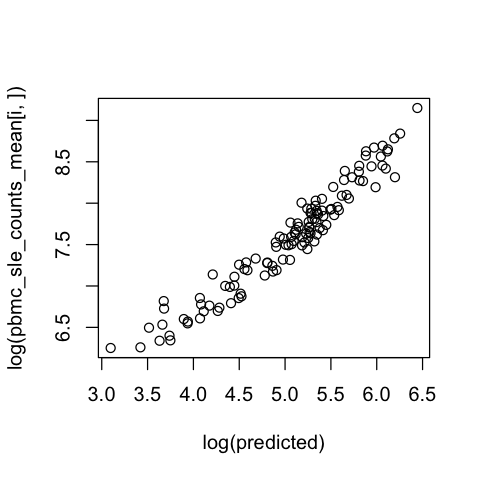

[1] 0.3488375

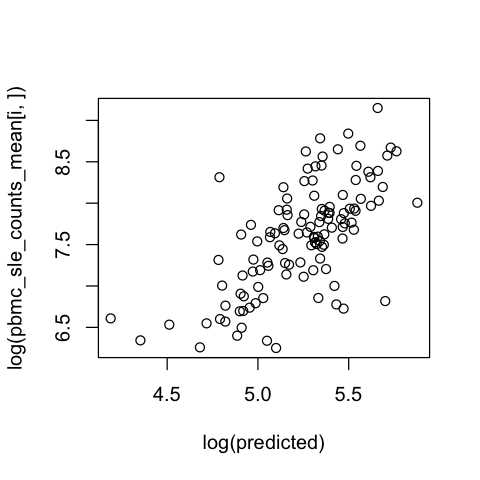

[1] 0.9737395

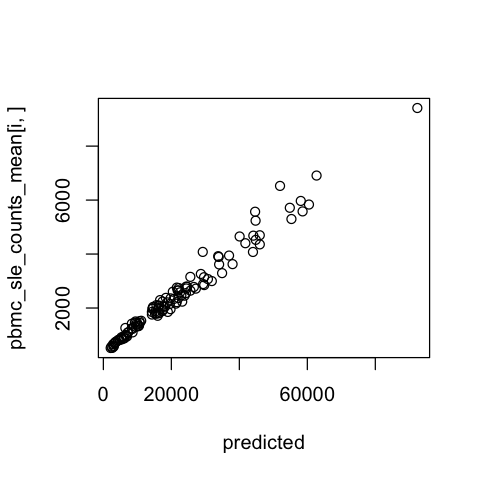

In [194]:
options(repr.plot.width = 4, repr.plot.height = 4)
i=2
i=grep("^CD22$",expr_gene_names)[1]
predicted <- rowSums(cbind(cm_sle_counts_global_mean[i]*cm_sle_prop/100,
                               th_sle_counts_global_mean[i]*th_sle_prop/100,
                               b_sle_counts_global_mean[i]*b_sle_prop/100,
                               nk_sle_counts_global_mean[i]*nk_sle_prop/100, 
                               ncm_sle_counts_global_mean[i]*ncm_sle_prop/100,
                               tc_sle_counts_global_mean[i]*tc_sle_prop/100), na.rm=T)
plot(log(predicted), log(pbmc_sle_counts_mean[i,]))
cor(predicted, pbmc_sle_counts_mean[i,])^2
output_sle_prop_noint[i,"adj r2"]

predicted <- rowSums(cbind(cm_sle_counts_mean[i,]*cm_sle_prop_global_mean, 
                              th_sle_counts_mean[i,]*th_sle_prop_global_mean, 
                              b_sle_counts_mean[i,]*b_sle_prop_global_mean,
                              nk_sle_counts_mean[i,]*nk_sle_prop_global_mean, 
                               ncm_sle_counts_mean[i,]*ncm_sle_prop_global_mean,
                              tc_sle_counts_mean[i,]*tc_sle_prop_global_mean), na.rm=T)
##                          dc_sle_counts_mean[i,]*dc_sle_prop_global_mean), na.rm=T)

plot(log(predicted), log(pbmc_sle_counts_mean[i,]))
cor(predicted, pbmc_sle_counts_mean[i,])^2

predicted <- rowSums(cbind(cm_sle_counts_mean[i,]*cm_sle_prop, 
                              th_sle_counts_mean[i,]*th_sle_prop, 
                              b_sle_counts_mean[i,]*b_sle_prop,
                              nk_sle_counts_mean[i,]*nk_sle_prop, 
                               ncm_sle_counts_mean[i,]*ncm_sle_prop,
                              tc_sle_counts_mean[i,]*tc_sle_prop,
                          dc_sle_counts_mean[i,]*dc_sle_prop), na.rm=T)
plot(predicted, pbmc_sle_counts_mean[i,])
cor(predicted, pbmc_sle_counts_mean[i,])^2



### Now, let's downsample to 46 and redo SLE

In [195]:
cm_sle_down_counts_global_mean <- apply(exp(cm_sle_expr[,samples]),1,mean)
th_sle_down_counts_global_mean <- apply(exp(th_sle_expr[,samples]),1,mean)
tc_sle_down_counts_global_mean <- apply(exp(tc_sle_expr[,samples]),1,mean)
b_sle_down_counts_global_mean <- apply(exp(b_sle_expr[,samples]),1,mean)
nk_sle_down_counts_global_mean <- apply(exp(nk_sle_expr[,samples]),1,mean)
ncm_sle_down_counts_global_mean <- apply(exp(ncm_sle_expr[,samples]),1,mean)
dc_sle_down_counts_global_mean <- apply(exp(dc_sle_expr[,samples]),1,mean)

# cm_sle_down_counts_global_mean <- rowSums(exp(cm_sle_expr[,samples]))/sum((joined_pivot_sle$counts*cm_sle_prop/100)[samples])
# th_sle_down_counts_global_mean <- rowSums(exp(th_sle_expr[,samples]))/sum((joined_pivot_sle$counts*th_sle_prop/100)[samples])
# tc_sle_down_counts_global_mean <- rowSums(exp(tc_sle_expr[,samples]))/sum((joined_pivot_sle$counts*tc_sle_prop/100)[samples])
# b_sle_down_counts_global_mean <- rowSums(exp(b_sle_expr[,samples]),na.rm=T)/sum((joined_pivot_sle$counts*b_sle_prop/100)[samples],na.rm=T)
# nk_sle_down_counts_global_mean <- rowSums(exp(nk_sle_expr[,samples]))/sum((joined_pivot_sle$counts*nk_sle_prop/100)[samples])
# ncm_sle_down_counts_global_mean <- rowSums(exp(ncm_sle_expr[,samples]))/sum((joined_pivot_sle$counts*ncm_sle_prop/100)[samples])
# dc_sle_down_counts_global_mean <- rowSums(exp(dc_sle_expr[,samples]),na.rm=T)/sum((joined_pivot_sle$counts*dc_sle_prop/100)[samples],na.rm=T)

output_sle_down_direct_global_prop <- NULL;

for(i in 1:nrow(pbmc_sle_counts[match(expr_gene_names, counts_gene_names),samples])) {    
    predicted <- rowSums(cbind(cm_sle_counts_global_mean[i]*cm_sle_prop[samples]/100, 
                               th_sle_counts_global_mean[i]*th_sle_prop[samples]/100, 
                               b_sle_counts_global_mean[i]*b_sle_prop[samples]/100, 
                               nk_sle_counts_global_mean[i]*nk_sle_prop[samples]/100, 
                               ncm_sle_counts_global_mean[i]*ncm_sle_prop[samples]/100, 
                               tc_sle_counts_global_mean[i]*tc_sle_prop[samples]/100), na.rm=T)
##                               dc_sle_counts_global_mean[i]*dc_sle_prop[samples]/100), na.rm=T)

    output_sle_down_direct_global_prop <- rbind(output_sle_down_direct_global_prop,
                                                c(cor(log(predicted),pbmc_sle_expr_std[i,samples])^2*100, 1-cor(log(predicted),pbmc_sle_expr_std[i,samples])^2*100))
}


rownames(output_sle_down_direct_global_prop) <- counts_gene_names[match(expr_gene_names, counts_gene_names)];
colnames(output_sle_down_direct_global_prop) <- c("r2", "res")

output_sle_down_direct_global_expr <- NULL;

cm_sle_down_prop_global_mean <- sum((joined_pivot_sle$counts*cm_sle_prop/100)[samples],na.rm=T)/sum(joined_pivot_sle$counts[samples])
th_sle_down_prop_global_mean <- sum((joined_pivot_sle$counts*th_sle_prop/100)[samples],na.rm=T)/sum(joined_pivot_sle$counts[samples])
tc_sle_down_prop_global_mean <- sum((joined_pivot_sle$counts*tc_sle_prop/100)[samples],na.rm=T)/sum(joined_pivot_sle$counts[samples])
b_sle_down_prop_global_mean <- sum((joined_pivot_sle$counts*b_sle_prop/100)[samples],na.rm=T)/sum(joined_pivot_sle$counts[samples],na.rm=T)
nk_sle_down_prop_global_mean <- sum((joined_pivot_sle$counts*nk_sle_prop/100)[samples],na.rm=T)/sum(joined_pivot_sle$counts[samples])
ncm_sle_down_prop_global_mean <- sum((joined_pivot_sle$counts*ncm_sle_prop/100)[samples],na.rm=T)/sum(joined_pivot_sle$counts[samples])
dc_sle_down_prop_global_mean <- sum((joined_pivot_sle$counts*dc_sle_prop/100)[samples],na.rm=T)/sum(joined_pivot_sle$counts[samples],na.rm=T)

for(i in 1:nrow(pbmc_sle_counts[match(expr_gene_names, counts_gene_names),])) {
   predicted <- rowSums(cbind(cm_sle_counts_mean[i,samples]*cm_sle_down_prop_global_mean,
                              th_sle_counts_mean[i,samples]*th_sle_down_prop_global_mean, 
                              b_sle_counts_mean[i,samples]*b_sle_down_prop_global_mean, 
                              nk_sle_counts_mean[i,samples]*nk_sle_down_prop_global_mean,
                              ncm_sle_counts_mean[i,samples]*ncm_sle_down_prop_global_mean, 
                              tc_sle_counts_mean[i,samples]*tc_sle_down_prop_global_mean), na.rm=T)
##                              dc_sle_counts_mean[i,samples]*dc_sle_down_prop_global_mean), na.rm=T)

    output_sle_down_direct_global_expr <- rbind(output_sle_down_direct_global_expr, 
                                                c(cor(log(predicted),pbmc_sle_expr_std[i,samples])^2*100, 1-cor(log(predicted),pbmc_sle_expr_std[i,samples])^2*100))
  
}


## Finally, processed the healthy

In [196]:
joined_pivot_healthy <- joined_pivot[match(colnames(pbmc_healthy_expr), joined_pivot$ind_cov),]

cm_healthy_counts_mean <- exp(cm_healthy_expr)
th_healthy_counts_mean <- exp(th_healthy_expr)
tc_healthy_counts_mean <- exp(tc_healthy_expr)
b_healthy_counts_mean <- exp(b_healthy_expr)
nk_healthy_counts_mean <- exp(nk_healthy_expr)
ncm_healthy_counts_mean <- exp(ncm_healthy_expr)
dc_healthy_counts_mean <- exp(dc_healthy_expr)
pbmc_healthy_counts_mean <- exp(pbmc_healthy_expr)


# cm_healthy_counts_mean <- sweep(exp(cm_healthy_expr), 2, joined_pivot_healthy$counts*cm_healthy_prop/100, "/")
# th_healthy_counts_mean <- sweep(exp(th_healthy_expr), 2, joined_pivot_healthy$counts*th_healthy_prop/100, "/")
# tc_healthy_counts_mean <- sweep(exp(tc_healthy_expr), 2, joined_pivot_healthy$counts*tc_healthy_prop/100, "/")
# b_healthy_counts_mean <- sweep(exp(b_healthy_expr), 2, joined_pivot_healthy$counts*b_healthy_prop/100, "/")
# nk_healthy_counts_mean <- sweep(exp(nk_healthy_expr), 2, joined_pivot_healthy$counts*nk_healthy_prop/100, "/")
# ncm_healthy_counts_mean <- sweep(exp(ncm_healthy_expr), 2, joined_pivot_healthy$counts*ncm_healthy_prop/100, "/")
# dc_healthy_counts_mean <- sweep(exp(dc_healthy_expr), 2, joined_pivot_healthy$counts*dc_healthy_prop/100, "/")
# pbmc_healthy_counts_mean <- sweep(exp(pbmc_healthy_expr), 2, joined_pivot_healthy$counts, "/")

cm_healthy_counts_global_mean <- apply(exp(cm_healthy_expr),1,mean)
th_healthy_counts_global_mean <- apply(exp(th_healthy_expr),1,mean)
tc_healthy_counts_global_mean <- apply(exp(tc_healthy_expr),1,mean)
b_healthy_counts_global_mean <- apply(exp(b_healthy_expr),1,mean)
nk_healthy_counts_global_mean <- apply(exp(nk_healthy_expr),1,mean)
ncm_healthy_counts_global_mean <- apply(exp(ncm_healthy_expr),1,mean)
dc_healthy_counts_global_mean <- apply(exp(dc_healthy_expr),1,mean)

# cm_healthy_counts_global_mean <- rowSums(exp(cm_healthy_expr))/sum(joined_pivot_healthy$counts*cm_healthy_prop/100, na.rm=T)
# th_healthy_counts_global_mean <- rowSums(exp(th_healthy_expr))/sum(joined_pivot_healthy$counts*th_healthy_prop/100, na.rm=T)
# tc_healthy_counts_global_mean <- rowSums(exp(tc_healthy_expr))/sum(joined_pivot_healthy$counts*tc_healthy_prop/100, na.rm=T)
# b_healthy_counts_global_mean <- rowSums(exp(b_healthy_expr))/sum(joined_pivot_healthy$counts*b_healthy_prop/100, na.rm=T)
# nk_healthy_counts_global_mean <- rowSums(exp(nk_healthy_expr))/sum(joined_pivot_healthy$counts*nk_healthy_prop/100, na.rm=T)
# ncm_healthy_counts_global_mean <- rowSums(exp(ncm_healthy_expr))/sum(joined_pivot_healthy$counts*ncm_healthy_prop/100, na.rm=T)
# dc_healthy_counts_global_mean <- rowSums(exp(dc_healthy_expr))/sum(joined_pivot_healthy$counts*dc_healthy_prop/100, na.rm=T)

##healthy_counts_means <- cbind(cm_healthy_counts_mean, th_healthy_counts_mean, tc_healthy_counts_mean, b_healthy_counts_mean, nk_healthy_counts_mean, ncm_healthy_counts_mean, dc_healthy_counts_mean)

output_healthy_direct_global_prop <- NULL;

for(i in 1:nrow(pbmc_healthy_counts[match(expr_gene_names, counts_gene_names),])) {    
    predicted <- rowSums(cbind(cm_healthy_counts_global_mean[i]*cm_healthy_prop/100,
                               th_healthy_counts_global_mean[i]*th_healthy_prop/100,
                               b_healthy_counts_global_mean[i]*b_healthy_prop/100,
                               nk_healthy_counts_global_mean[i]*nk_healthy_prop/100, 
                               ncm_healthy_counts_global_mean[i]*ncm_healthy_prop/100,
                               tc_healthy_counts_global_mean[i]*tc_healthy_prop/100), na.rm=T)
##                               dc_healthy_counts_global_mean[i]*dc_healthy_prop/100),na.rm=T)

    output_healthy_direct_global_prop <- rbind(output_healthy_direct_global_prop, 
                                               c(cor(log(predicted),pbmc_healthy_expr_std[i,])^2*100, 1-cor(log(predicted),pbmc_healthy_expr_std[i,])^2*100))
}


rownames(output_healthy_direct_global_prop) <- counts_gene_names[match(expr_gene_names, counts_gene_names)];
colnames(output_healthy_direct_global_prop) <- c("r2", "res")

output_healthy_direct_global_expr <- NULL;

cm_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*cm_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts)
th_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*th_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts)
tc_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*tc_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts)
b_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*b_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts)
nk_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*nk_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts)
ncm_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*ncm_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts)
dc_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*dc_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts)

for(i in 1:nrow(pbmc_healthy_counts[match(expr_gene_names, counts_gene_names),])) {
   predicted <- rowSums(cbind(cm_healthy_counts_mean[i,]*cm_healthy_prop_global_mean,
                              th_healthy_counts_mean[i,]*th_healthy_prop_global_mean,
                              b_healthy_counts_mean[i,]*b_healthy_prop_global_mean,
                              nk_healthy_counts_mean[i,]*nk_healthy_prop_global_mean, 
                               ncm_healthy_counts_mean[i,]*ncm_healthy_prop_global_mean,
                              tc_healthy_counts_mean[i,]*tc_healthy_prop_global_mean), na.rm=T)
                              ##dc_healthy_counts_mean[i]*dc_healthy_prop_global_mean),na.rm=T)

   ##output_healthy_direct_global_expr <- rbind(output_healthy_direct_global_expr, c(var(predicted)/var(pbmc_healthy_counts_mean[i,],na.rm=T)*100, 100-var(predicted)/var(pbmc_healthy_counts_mean[i,],na.rm=T)*100))
  output_healthy_direct_global_expr <- rbind(output_healthy_direct_global_expr, 
                                         c(cor(log(predicted),pbmc_healthy_expr_std[i,])^2*100, 1-cor(log(predicted),pbmc_healthy_expr_std[i,])^2*100))
}

rownames(output_healthy_direct_global_expr) <- expr_gene_names;
colnames(output_healthy_direct_global_expr) <- c("r2", "res")

[1] 79.16981

[1] 78.22258

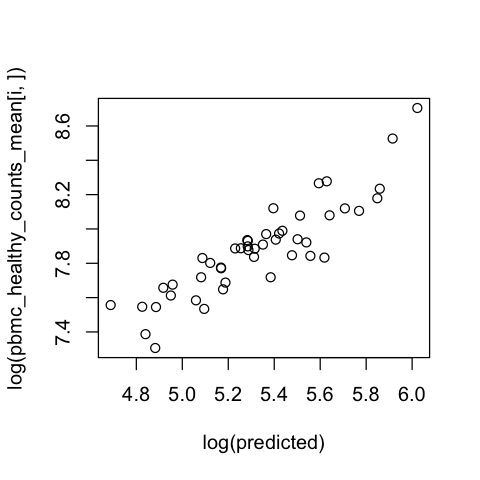

[1] 0.1285991

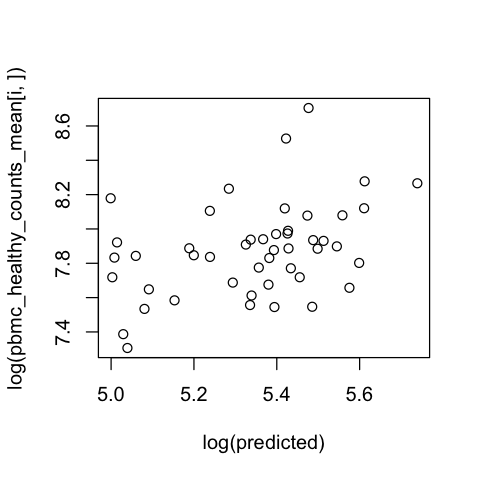

[1] 0.8966153

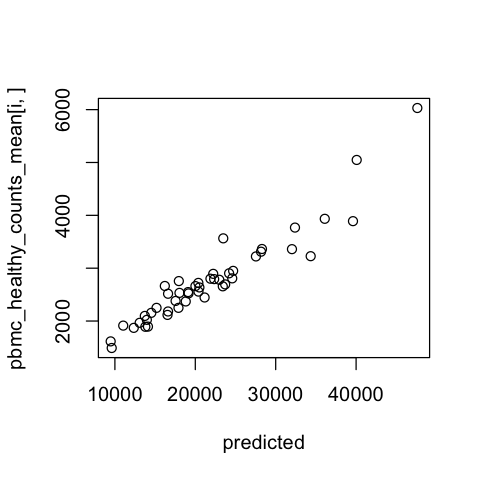

In [197]:
options(repr.plot.width = 4, repr.plot.height = 4)
i=10
i=grep("^CD22$",expr_gene_names)[1]
predicted <- rowSums(cbind(cm_healthy_counts_global_mean[i]*cm_healthy_prop/100,
                               th_healthy_counts_global_mean[i]*th_healthy_prop/100,
                               b_healthy_counts_global_mean[i]*b_healthy_prop/100,
                               nk_healthy_counts_global_mean[i]*nk_healthy_prop/100, 
                               ncm_healthy_counts_global_mean[i]*ncm_healthy_prop/100,
                               tc_healthy_counts_global_mean[i]*tc_healthy_prop/100), na.rm=T)
plot(log(predicted), log(pbmc_healthy_counts_mean[i,]))
cor(predicted, pbmc_healthy_counts_mean[i,])^2*100
output_healthy_prop_noint[i,"adj r2"]

predicted <- rowSums(cbind(cm_healthy_counts_mean[i,]*cm_healthy_prop_global_mean, 
                              th_healthy_counts_mean[i,]*th_healthy_prop_global_mean, 
                              b_healthy_counts_mean[i,]*b_healthy_prop_global_mean,
                              nk_healthy_counts_mean[i,]*nk_healthy_prop_global_mean, 
                               ncm_healthy_counts_mean[i,]*ncm_healthy_prop_global_mean,
                              tc_healthy_counts_mean[i,]*tc_healthy_prop_global_mean,
                          dc_healthy_counts_mean[i,]*dc_healthy_prop_global_mean), na.rm=T)
plot(log(predicted), log(pbmc_healthy_counts_mean[i,]))
cor(predicted, pbmc_healthy_counts_mean[i,])^2


predicted <- rowSums(cbind(cm_healthy_counts_mean[i,]*cm_healthy_prop, 
                              th_healthy_counts_mean[i,]*th_healthy_prop, 
                              b_healthy_counts_mean[i,]*b_healthy_prop,
                              nk_healthy_counts_mean[i,]*nk_healthy_prop, 
                               ncm_healthy_counts_mean[i,]*ncm_healthy_prop,
                              tc_healthy_counts_mean[i,]*tc_healthy_prop,
                          dc_healthy_counts_mean[i,]*dc_healthy_prop), na.rm=T)
plot(predicted, pbmc_healthy_counts_mean[i,])
cor(predicted, pbmc_healthy_counts_mean[i,])^2

In [198]:
# i = 6808;
# i = grep("ERAP1", expr_gene_names)

# cm_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*cm_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts,na.rm=T)
# th_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*th_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts,na.rm=T)
# tc_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*tc_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts,na.rm=T)
# b_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*b_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts,na.rm=T)
# nk_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*nk_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts,na.rm=T)
# ncm_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*ncm_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts,na.rm=T)
# dc_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*dc_healthy_prop/100,na.rm=T)/sum(joined_pivot_healthy$counts,na.rm=T)

# predicted <- rowSums(cbind(cm_healthy_counts_mean[i,]*cm_healthy_prop_global_mean, th_healthy_counts_mean[i,]*th_healthy_prop_global_mean, b_healthy_counts_mean[i,]*b_healthy_prop_global_mean, nk_healthy_counts_mean[i,]*nk_healthy_prop_global_mean, 
#                     ncm_healthy_counts_mean[i,]*ncm_healthy_prop_global_mean, tc_healthy_counts_mean[i,]*tc_healthy_prop_global_mean, dc_healthy_counts_mean[i,]*dc_healthy_prop_global_mean), na.rm=T)

# plot(predicted, pbmc_healthy_counts_mean[i,])

# cm_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*cm_healthy_prop/100)/sum(joined_pivot_healthy$counts)
# th_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*th_healthy_prop/100)/sum(joined_pivot_healthy$counts)
# tc_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*tc_healthy_prop/100)/sum(joined_pivot_healthy$counts)
# b_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*b_healthy_prop/100)/sum(joined_pivot_healthy$counts)
# nk_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*nk_healthy_prop/100)/sum(joined_pivot_healthy$counts)
# ncm_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*ncm_healthy_prop/100)/sum(joined_pivot_healthy$counts)
# dc_healthy_prop_global_mean <- sum(joined_pivot_healthy$counts*dc_healthy_prop/100)/sum(joined_pivot_healthy$counts)

# predicted2 <- rowSums(cbind(cm_healthy_counts_mean[i,]*cm_healthy_prop_global_mean, th_healthy_counts_mean[i,]*th_healthy_prop_global_mean, b_healthy_counts_mean[i,]*b_healthy_prop_global_mean, nk_healthy_counts_mean[i,]*nk_healthy_prop_global_mean, 
#                     ncm_healthy_counts_mean[i,]*ncm_healthy_prop_global_mean, tc_healthy_counts_mean[i,]*tc_healthy_prop_global_mean, dc_healthy_counts_mean[i,]*dc_healthy_prop_global_mean), na.rm=T)
# plot(predicted2, pbmc_healthy_counts_mean[i,])

## Plotting

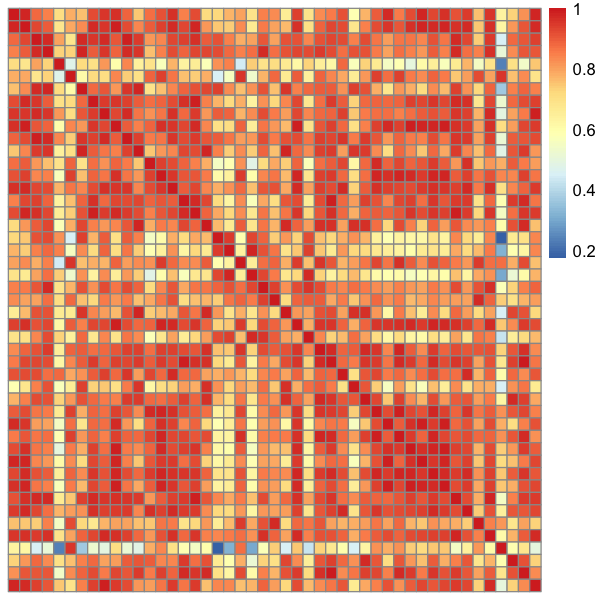

In [199]:
options(repr.plot.width = 5, repr.plot.height = 5)
pheatmap(cor(t(cbind(cm_healthy_prop, th_healthy_prop, b_healthy_prop, nk_healthy_prop, ncm_healthy_prop, tc_healthy_prop, dc_healthy_prop))),cluster_rows=F,cluster_cols=F)

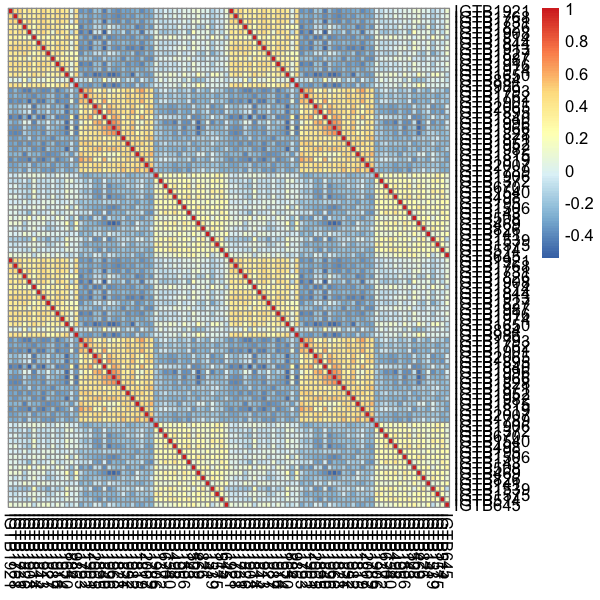

In [200]:
options(repr.plot.width = 5, repr.plot.height = 5)
pheatmap(cor(cbind(pbmc_healthy_expr_std,t(apply(pbmc_healthy_counts_mean,1,function(x) {(x-mean(x))/sd(x)})))),cluster_rows=F,cluster_cols=F)

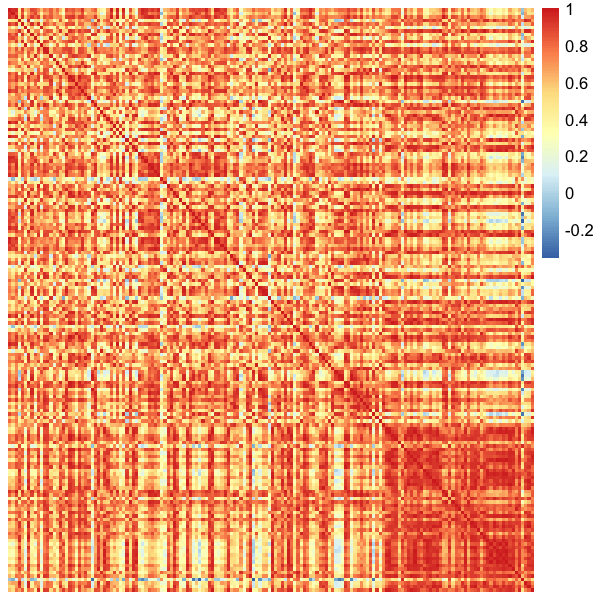

In [201]:
options(repr.plot.width = 5, repr.plot.height = 5)
pheatmap(cor(t(cbind(cm_prop, th_prop, b_prop, nk_prop, ncm_prop, tc_prop, dc_prop))),cluster_rows=F,cluster_cols=F)

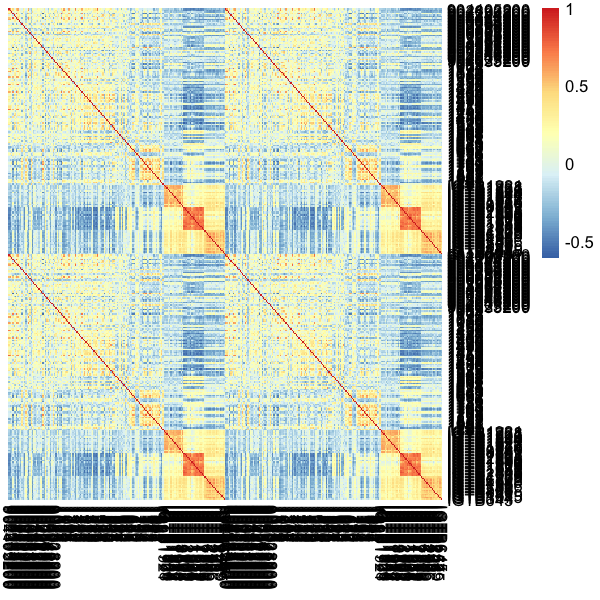

In [202]:
options(repr.plot.width = 5, repr.plot.height = 5)
pheatmap(cor(cbind(pbmc_expr_std,t(apply(pbmc_counts_mean,1,function(x) {(x-mean(x))/sd(x)})))),cluster_rows=F,cluster_cols=F)

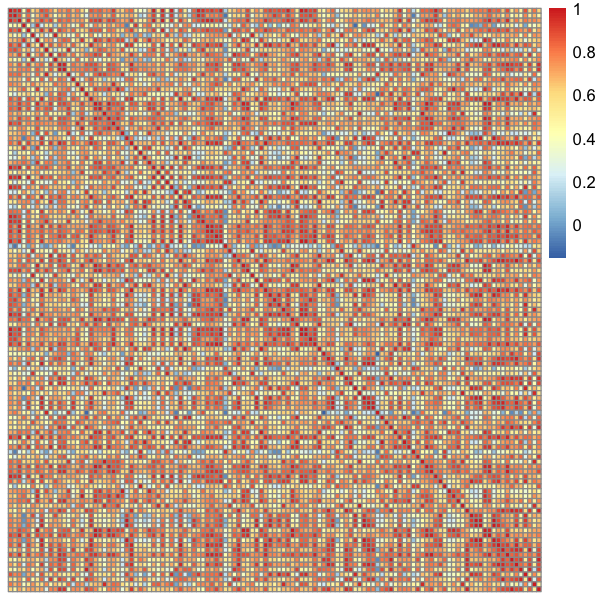

In [203]:
options(repr.plot.width = 5, repr.plot.height = 5)
pheatmap(cor(t(cbind(cm_sle_prop, th_sle_prop, b_sle_prop, nk_sle_prop, ncm_sle_prop, tc_sle_prop, dc_sle_prop))),cluster_rows=F,cluster_cols=F)

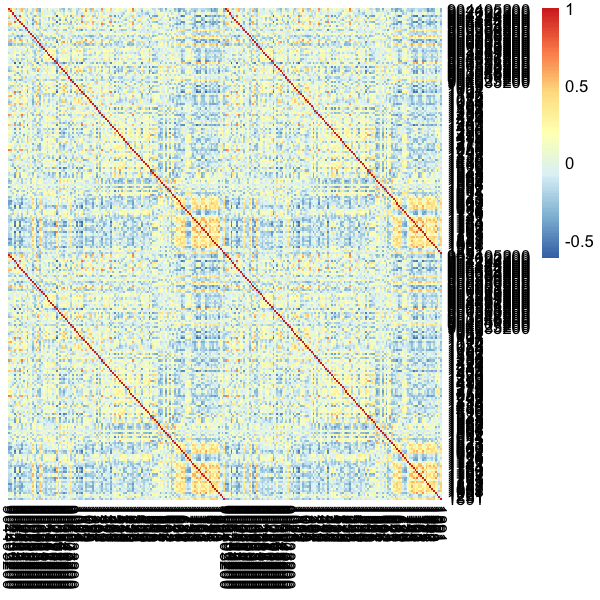

In [204]:
options(repr.plot.width = 5, repr.plot.height = 5)
pheatmap(cor(cbind(pbmc_sle_expr_std,t(apply(pbmc_sle_counts_mean,1,function(x) {(x-mean(x))/sd(x)})))),cluster_rows=F,cluster_cols=F)

cor        prop_mean expr_mean sum_mean 
all_noint      -0.6382174 21.00394  78.99593   99.99987
sle_noint      -0.7344679 20.13005  77.19966   97.32971
sle_down_noint -0.5336652 20.23492  79.03329   99.26820
healthy_noint  -0.5138207 17.17524  83.14209  100.31733

cM        Th        B        NK       ncM      Tc       
all_noint_prop       6.550037  4.059750 2.290141 1.390288 1.700561  1.198287
all_noint_expr       9.864590 15.752106 3.738308 1.982496 2.224216  8.899064
sle_noint_prop       5.587880  4.005919 3.003618 2.122952 2.148751  1.839134
sle_noint_expr       9.162077 17.686458 3.967223 2.126500 2.640276  8.876581
sle_down_noint_prop  6.219733  4.455861 3.757274 3.851493 3.381788  4.715944
sle_down_noint_expr 10.589246 20.825452 4.324331 2.843942 3.073081  8.895177
healthy_noint_prop   6.233008  3.173706 5.153048 4.153889 2.959187  1.731355
healthy_noint_expr  16.212910 11.827618 5.890492 3.232771 2.794772 11.384022
                    total.r2 adj.r2  
all_noint_prop      17.18906 21.00394
all_noint_expr      42.46078 78.99593
sle_noint_prop      18.70825 20.13005
sle_noint_expr      44.45912 77.19966
sle_down_noint_prop 26.38209 20.23492
sle_down_noint_expr 50.55123 79.03329
healthy_noint_prop  23.40419 17.17524
healthy_noint_expr  51.34258 83.14209

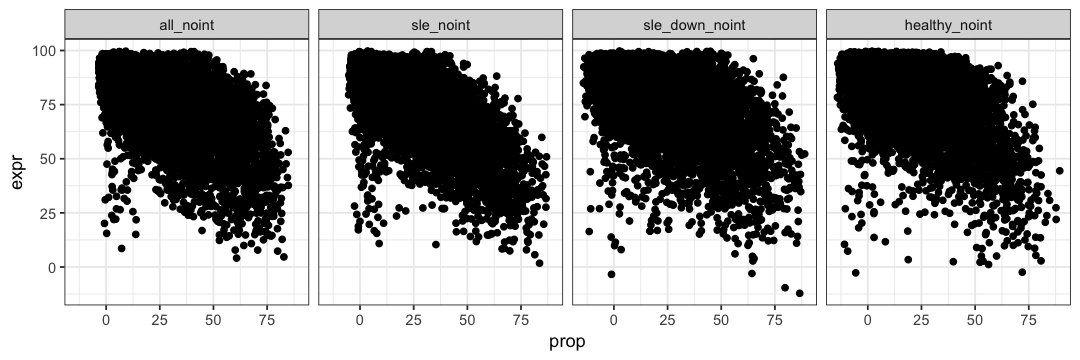

cor        prop_mean expr_mean sum_mean
all_direct      -0.6044387 14.78828  72.57871  87.36700
sle_direct      -0.6639556 14.07968  70.39750  84.47717
sle_down_direct -0.5116672 13.17879  72.24425  85.42303
healthy_direct  -0.5882337 10.56066  75.07181  85.63248

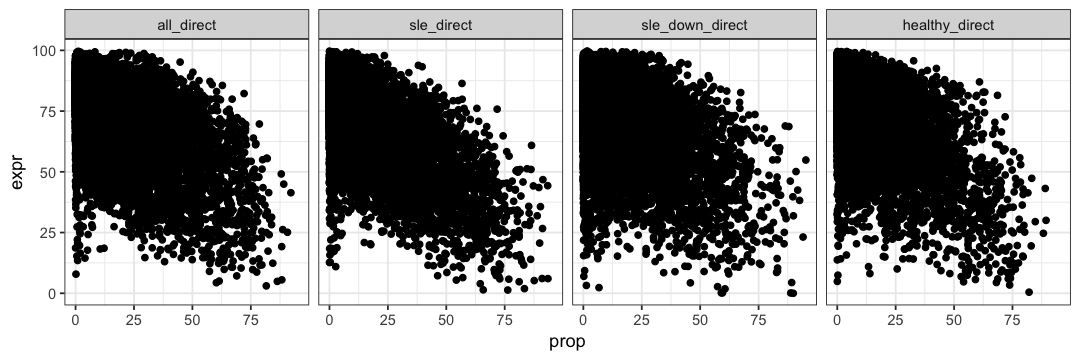

In [205]:
output_noint_df <- data.frame(prop=output_prop_noint[,"adj r2"], expr=output_expr_noint[,"adj r2"], type="all_noint")
output_sle_noint_df <- data.frame(prop=output_sle_prop_noint[,"adj r2"], expr=output_sle_expr_noint[,"adj r2"], type="sle_noint")
output_sle_down_noint_df <- data.frame(prop=output_sle_down_prop_noint[,"adj r2"], expr=output_sle_down_expr_noint[,"adj r2"], type="sle_down_noint")
output_healthy_noint_df <- data.frame(prop=output_healthy_prop_noint[,"adj r2"], expr=output_healthy_expr_noint[,"adj r2"], type="healthy_noint")

df <- rbind(output_noint_df, output_sle_noint_df, output_sle_down_noint_df, output_healthy_noint_df)

options(repr.plot.width = 9, repr.plot.height = 3)
ggplot(aes(prop, expr), data=df)+geom_point()+facet_grid(~type)+theme_bw()

df2 <- data.frame(cor=c(cor(output_prop_noint[,"adj r2"], output_expr_noint[,"adj r2"]), cor(output_sle_prop_noint[,"adj r2"], output_sle_expr_noint[,"adj r2"]), cor(output_sle_down_prop_noint[,"adj r2"], output_sle_down_expr_noint[,"adj r2"]), cor(output_healthy_prop_noint[,"adj r2"], output_healthy_expr_noint[,"adj r2"])),
      prop_mean=c(mean(output_prop_noint[,"adj r2"]), mean(output_sle_prop_noint[,"adj r2"]), mean(output_sle_down_prop_noint[,"adj r2"]), mean(output_healthy_prop_noint[,"adj r2"])),
      expr_mean=c(mean(output_expr_noint[,"adj r2"]), mean(output_sle_expr_noint[,"adj r2"]), mean(output_sle_down_expr_noint[,"adj r2"]), mean(output_healthy_expr_noint[,"adj r2"])),
      sum_mean = c(mean(output_prop_noint[,"adj r2"]+output_expr_noint[,"adj r2"]), mean(output_sle_prop_noint[,"adj r2"]+output_sle_expr_noint[,"adj r2"]), mean(output_sle_down_prop_noint[,"adj r2"]+output_sle_down_expr_noint[,"adj r2"]), mean(output_healthy_prop_noint[,"adj r2"]+output_healthy_expr_noint[,"adj r2"])))
rownames(df2) <- c("all_noint", "sle_noint", "sle_down_noint", "healthy_noint")

df2

df3 <- rbind(data.frame(t(apply(output_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_expr_noint,2,mean,na.rm=T))),
             data.frame(t(apply(output_sle_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_expr_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_down_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_sle_down_expr_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_healthy_prop_noint,2,mean,na.rm=T))),
            data.frame(t(apply(output_healthy_expr_noint,2,mean,na.rm=T))))

rownames(df3) <- c("all_noint_prop", "all_noint_expr", "sle_noint_prop", "sle_noint_expr", "sle_down_noint_prop", "sle_down_noint_expr", "healthy_noint_prop", "healthy_noint_expr")

df3

output_direct_global_df <- data.frame(prop=output_direct_global_prop[,1], expr=output_direct_global_expr[,1], type="all_direct")
output_sle_direct_global_df <- data.frame(prop=output_sle_direct_global_prop[,1], expr=output_sle_direct_global_expr[,1], type="sle_direct")
output_sle_down_direct_global_df <- data.frame(prop=output_sle_down_direct_global_prop[,1], expr=output_sle_down_direct_global_expr[,1], type="sle_down_direct")
output_healthy_direct_global_df <- data.frame(prop=output_healthy_direct_global_prop[,1], expr=output_healthy_direct_global_expr[,1], type="healthy_direct")

df <- rbind(output_direct_global_df, output_sle_direct_global_df, output_sle_down_direct_global_df, output_healthy_direct_global_df)

options(repr.plot.width = 9, repr.plot.height = 3)
##ggplot(aes(prop, expr), data=df)+geom_point()+facet_grid(~type)+theme_bw()+xlim(c(0,100))+ylim(c(0,100))
ggplot(aes(prop, expr), data=df)+geom_point()+facet_grid(~type)+theme_bw()

df2 <- data.frame(cor=c(cor(output_direct_global_prop[,1], output_direct_global_expr[,1]), 
                        cor(output_sle_direct_global_prop[,1], output_sle_direct_global_expr[,1]), 
                        cor(output_sle_down_direct_global_prop[,1], output_sle_down_direct_global_expr[,1]),
                        cor(output_healthy_direct_global_prop[,1], output_healthy_direct_global_expr[,1])),
      prop_mean=c(mean(output_direct_global_prop[,1]), mean(output_sle_direct_global_prop[,1]), mean(output_sle_down_direct_global_prop[,1]), mean(output_healthy_direct_global_prop[,1])),
      expr_mean=c(mean(output_direct_global_expr[,1]), mean(output_sle_direct_global_expr[,1]), mean(output_sle_down_direct_global_expr[,1]), mean(output_healthy_direct_global_expr[,1])),
      sum_mean = c(mean(output_direct_global_prop[,1]+output_direct_global_expr[,1]), mean(output_sle_direct_global_prop[,1]+output_sle_direct_global_expr[,1]), mean(output_sle_down_direct_global_prop[,1]+output_sle_down_direct_global_expr[,1]), mean(output_healthy_direct_global_prop[,1]+output_healthy_direct_global_expr[,1])))
rownames(df2) <- c("all_direct", "sle_direct", "sle_down_direct", "healthy_direct")

df2

# df3 <- rbind(data.frame(t(apply(output_direct_global_prop,2,mean,na.rm=T))),
#             data.frame(t(apply(output_direct_global_expr,2,mean,na.rm=T))),
#              data.frame(t(apply(output_sle_direct_global_prop,2,mean,na.rm=T))),
#             data.frame(t(apply(output_sle_direct_global_expr,2,mean,na.rm=T))),
#             data.frame(t(apply(output_sle_down_direct_global_prop,2,mean,na.rm=T))),
#             data.frame(t(apply(output_sle_down_direct_global_expr,2,mean,na.rm=T))),
#             data.frame(t(apply(output_healthy_direct_global_prop,2,mean,na.rm=T))),
#             data.frame(t(apply(output_healthy_direct_global_expr,2,mean,na.rm=T))))

# rownames(df3) <- c("all_direct_prop", "all_direct_expr", "sle_direct_prop", "sle_direct_expr", "sle_down_direct_prop", "sle_down_direct_expr", "healthy_direct_prop", "healthy_direct_expr")

# df3

## Compare to previous estimates using linear regression

Warning message:
“Removed 4808 rows containing missing values (geom_point).”

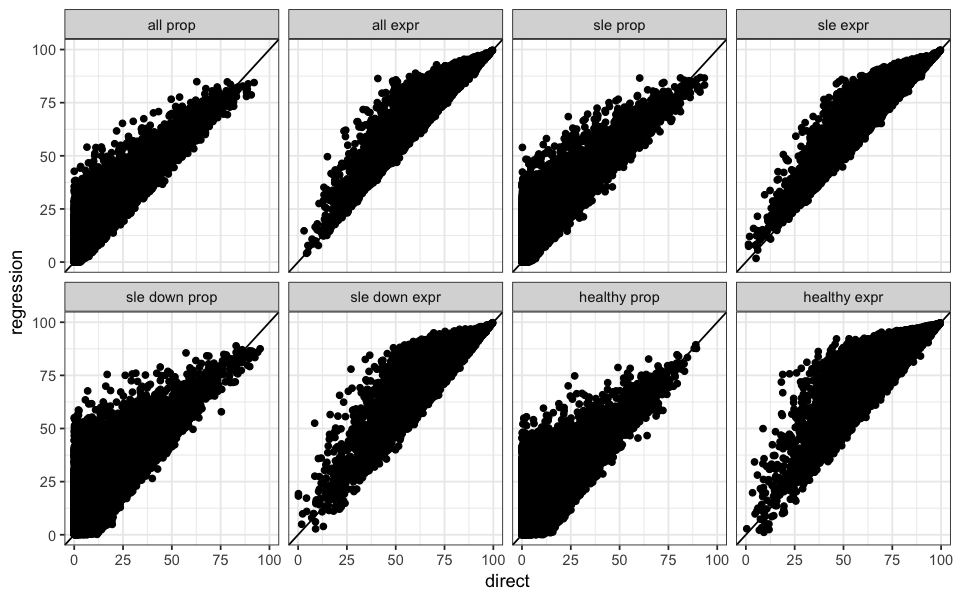

In [206]:
df <- rbind(data.frame(direct=output_direct_global_prop[,1], regression=output_prop_noint[,"adj r2"], type="all prop"),
            data.frame(direct=output_direct_global_expr[,1], regression=output_expr_noint[,"adj r2"], type="all expr"),
            
            data.frame(direct=output_sle_direct_global_prop[,1], regression=output_sle_prop_noint[,"adj r2"], type="sle prop"),
            data.frame(direct=output_sle_direct_global_expr[,1], regression=output_sle_expr_noint[,"adj r2"], type="sle expr"),
            
            data.frame(direct=output_sle_down_direct_global_prop[,1], regression=output_sle_down_prop_noint[,"adj r2"], type="sle down prop"),
            data.frame(direct=output_sle_down_direct_global_expr[,1], regression=output_sle_down_expr_noint[,"adj r2"], type="sle down expr"),
            
            data.frame(direct=output_healthy_direct_global_prop[,1], regression=output_healthy_prop_noint[,"adj r2"], type="healthy prop"),
            data.frame(direct=output_healthy_direct_global_expr[,1], regression=output_healthy_expr_noint[,"adj r2"], type="healthy expr"))
  
options(repr.plot.width = 8, repr.plot.height = 5)
ggplot(aes(direct, regression), data=df)+geom_point()+facet_wrap(~ type, nrow = 2)+theme_bw()+xlim(0,100)+ylim(0,100)+geom_abline(slope=1, intercept=0,
  na.rm = FALSE, show.legend = NA)
##ggplot(aes(direct, regression), data=df)+geom_point()+facet_wrap(~ type, nrow = 2)+theme_bw()+geom_abline(slope=1, intercept=0,
##  na.rm = FALSE, show.legend = NA)


In [207]:
cor(output_sle_direct_global_prop[,1], output_sle_prop_noint[,"adj r2"])
cor(output_sle_direct_global_expr[,1], output_sle_expr_noint[,"adj r2"])

cor(output_sle_down_direct_global_prop[,1], output_sle_down_prop_noint[,"adj r2"])
cor(output_sle_down_direct_global_expr[,1], output_sle_down_expr_noint[,"adj r2"])

cor(output_healthy_direct_global_prop[,1], output_healthy_prop_noint[,"adj r2"])
cor(output_healthy_direct_global_expr[,1], output_healthy_expr_noint[,"adj r2"])

[1] 0.908281

[1] 0.9421963

[1] 0.8033512

[1] 0.9108572

[1] 0.7667194

[1] 0.8888082

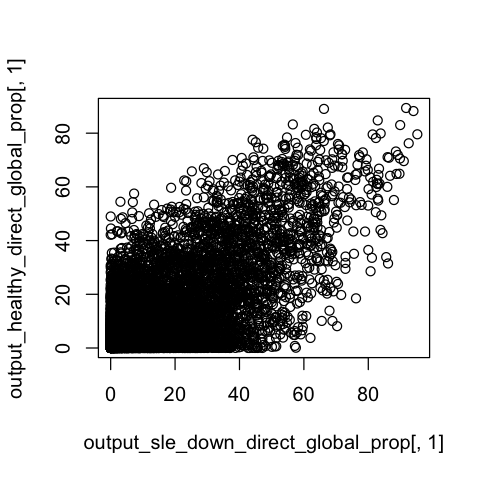

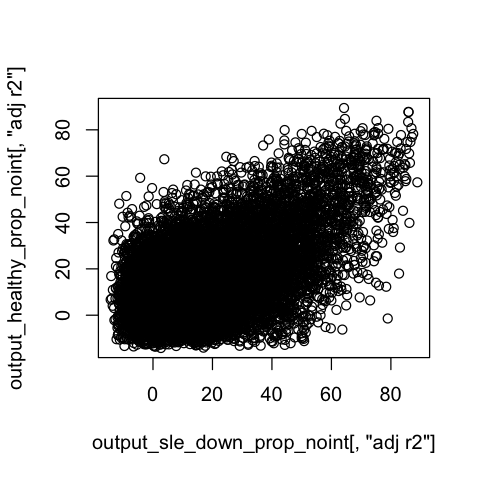

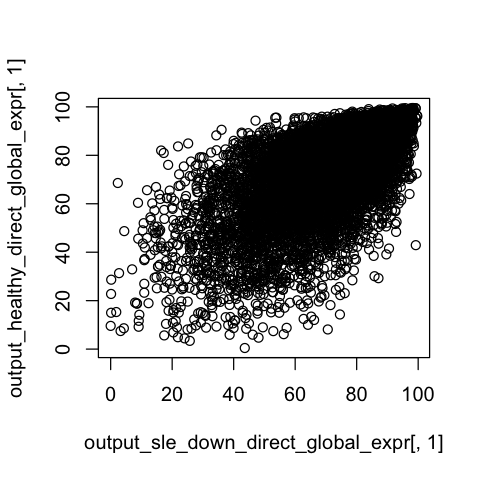

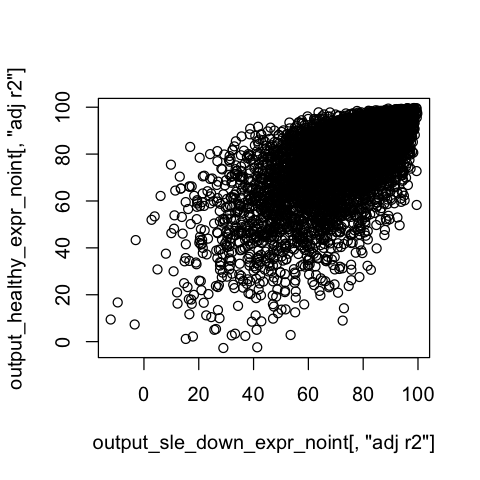

In [208]:
options(repr.plot.width = 4, repr.plot.height = 4)
plot(output_sle_down_direct_global_prop[,1], output_healthy_direct_global_prop[,1])
plot(output_sle_down_prop_noint[,"adj r2"], output_healthy_prop_noint[,"adj r2"])
plot(output_sle_down_direct_global_expr[,1], output_healthy_direct_global_expr[,1])
plot(output_sle_down_expr_noint[,"adj r2"], output_healthy_expr_noint[,"adj r2"])

# Load the cell type proportion estimates using the ```joined_pivot.txt``` generated by the Figure 1 code

In [209]:
# ifn = read.table("v2.ifn.sig.txt", sep=" ",header=T)
# ifn$name = sapply(ifn$name, function(x) {strsplit(as.character(x), "_")[[1]][[1]]})
# ifn

# match(colnames(pbmc_expr),joined_pivot$ind_cov)

# Correlate cell type specific expression with over all expression

No id variables; using all as measure variables
No id variables; using all as measure variables


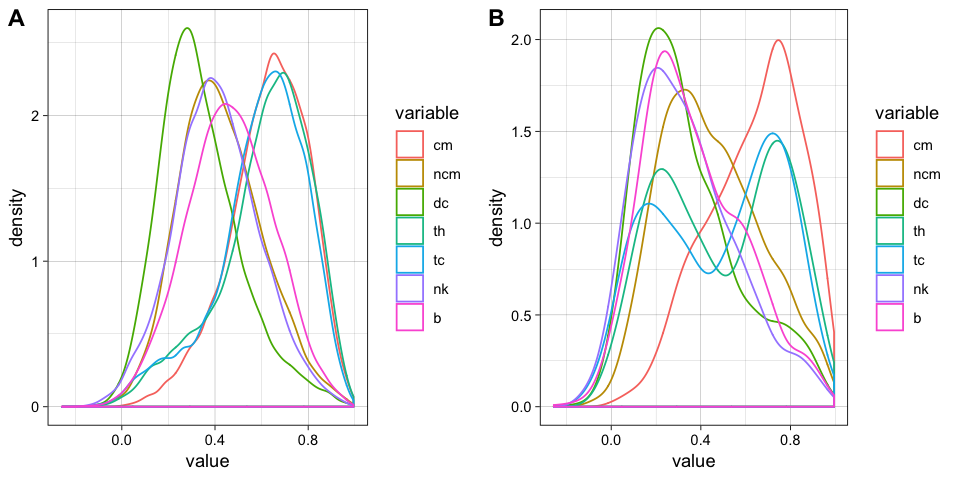

In [210]:
pbmc_cm_expr_cor <- sapply(1:nrow(pbmc_expr), function(i) {cor(pbmc_expr[i,],cm_expr[i,],use='complete.obs')})
pbmc_th_expr_cor <- sapply(1:nrow(pbmc_expr), function(i) {cor(pbmc_expr[i,],th_expr[i,],use='complete.obs')})
pbmc_b_expr_cor <- sapply(1:nrow(pbmc_expr), function(i) {cor(pbmc_expr[i,],b_expr[i,],use='complete.obs')})
pbmc_nk_expr_cor <- sapply(1:nrow(pbmc_expr), function(i) {cor(pbmc_expr[i,],nk_expr[i,],use='complete.obs')})
pbmc_ncm_expr_cor <- sapply(1:nrow(pbmc_expr), function(i) {cor(pbmc_expr[i,],ncm_expr[i,],use='complete.obs')})
pbmc_tc_expr_cor <- sapply(1:nrow(pbmc_expr), function(i) {cor(pbmc_expr[i,],tc_expr[i,],use='complete.obs')})
pbmc_dc_expr_cor <- sapply(1:nrow(pbmc_expr), function(i) {cor(pbmc_expr[i,],dc_expr[i,],use='complete.obs')})

mat_expr_cor <- data.frame(cm=pbmc_cm_expr_cor,
                           ncm=pbmc_ncm_expr_cor,
                             dc=pbmc_dc_expr_cor,
                           th=pbmc_th_expr_cor,
                           tc=pbmc_tc_expr_cor,
                          nk=pbmc_nk_expr_cor,
                          b=pbmc_b_expr_cor)
df_expr_cor <- melt(mat_expr_cor)
ggplot1 <- ggplot(aes(value,color=variable), data=df_expr_cor)+geom_density()+theme_linedraw();

mat_expr_cor_sig <- mat_expr_cor[match(pbmc_deseq_sig,expr_gene_names),]
df_expr_cor_sig <- melt(mat_expr_cor_sig)
ggplot2 <- ggplot(aes(value,color=variable), data=df_expr_cor_sig)+geom_density()+theme_linedraw();

options(repr.plot.width = 8, repr.plot.height = 4)
plot_grid(ggplot1, ggplot2, labels = "AUTO")

## Let's plot the shifts in distribution for just the SLE samples

No id variables; using all as measure variables
No id variables; using all as measure variables


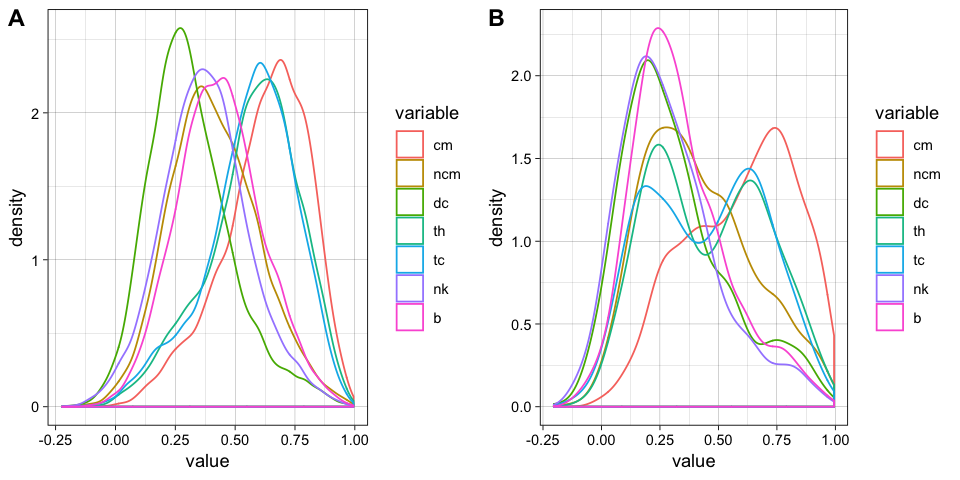

In [211]:
pbmc_cm_sle_expr_cor <- sapply(1:nrow(pbmc_sle_expr), function(i) {cor(pbmc_sle_expr[i,],cm_sle_expr[i,],use='complete.obs')})
pbmc_th_sle_expr_cor <- sapply(1:nrow(pbmc_sle_expr), function(i) {cor(pbmc_sle_expr[i,],th_sle_expr[i,],use='complete.obs')})
pbmc_b_sle_expr_cor <- sapply(1:nrow(pbmc_sle_expr), function(i) {cor(pbmc_sle_expr[i,],b_sle_expr[i,],use='complete.obs')})
pbmc_nk_sle_expr_cor <- sapply(1:nrow(pbmc_sle_expr), function(i) {cor(pbmc_sle_expr[i,],nk_sle_expr[i,],use='complete.obs')})
pbmc_ncm_sle_expr_cor <- sapply(1:nrow(pbmc_sle_expr), function(i) {cor(pbmc_sle_expr[i,],ncm_sle_expr[i,],use='complete.obs')})
pbmc_tc_sle_expr_cor <- sapply(1:nrow(pbmc_sle_expr), function(i) {cor(pbmc_sle_expr[i,],tc_sle_expr[i,],use='complete.obs')})
pbmc_dc_sle_expr_cor <- sapply(1:nrow(pbmc_sle_expr), function(i) {cor(pbmc_sle_expr[i,],dc_sle_expr[i,],use='complete.obs')})

mat_sle_expr_cor <- data.frame(cm=pbmc_cm_sle_expr_cor,
                           ncm=pbmc_ncm_sle_expr_cor,
                             dc=pbmc_dc_sle_expr_cor,
                           th=pbmc_th_sle_expr_cor,
                           tc=pbmc_tc_sle_expr_cor,
                          nk=pbmc_nk_sle_expr_cor,
                          b=pbmc_b_sle_expr_cor)
df_sle_expr_cor <- melt(mat_sle_expr_cor)
ggplot1 <- ggplot(aes(value,color=variable), data=df_sle_expr_cor)+geom_density()+theme_linedraw();

mat_sle_expr_cor_sig <- mat_sle_expr_cor[match(pbmc_deseq_sig,expr_gene_names),]
df_sle_expr_cor_sig <- melt(mat_sle_expr_cor_sig)
ggplot2 <- ggplot(aes(value,color=variable), data=df_sle_expr_cor_sig)+geom_density()+theme_linedraw();

options(repr.plot.width = 8, repr.plot.height = 4)
plot_grid(ggplot1, ggplot2, labels = "AUTO")

## Let's plot the shifts in distribution for just the healthy samples

No id variables; using all as measure variables
No id variables; using all as measure variables


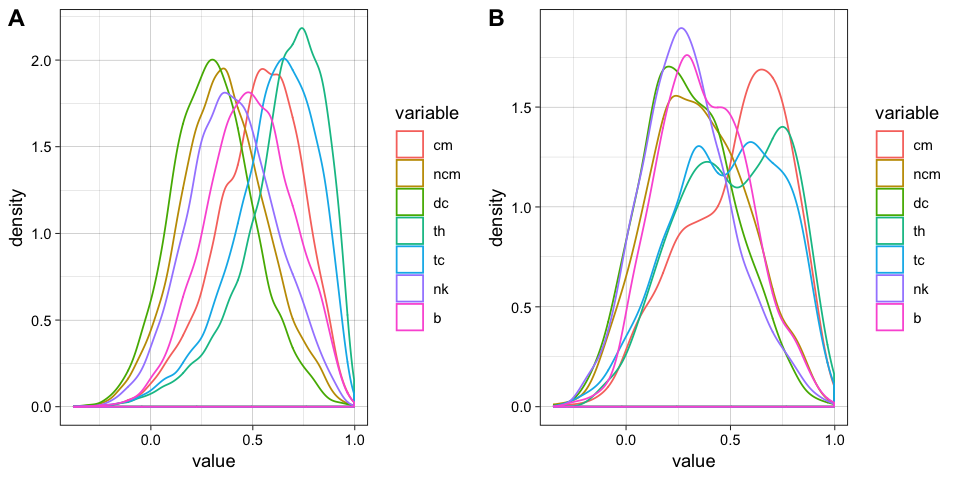

In [212]:
pbmc_cm_healthy_expr_cor <- sapply(1:nrow(pbmc_healthy_expr), function(i) {cor(pbmc_healthy_expr[i,],cm_healthy_expr[i,],use='complete.obs')})
pbmc_th_healthy_expr_cor <- sapply(1:nrow(pbmc_healthy_expr), function(i) {cor(pbmc_healthy_expr[i,],th_healthy_expr[i,],use='complete.obs')})
pbmc_b_healthy_expr_cor <- sapply(1:nrow(pbmc_healthy_expr), function(i) {cor(pbmc_healthy_expr[i,],b_healthy_expr[i,],use='complete.obs')})
pbmc_nk_healthy_expr_cor <- sapply(1:nrow(pbmc_healthy_expr), function(i) {cor(pbmc_healthy_expr[i,],nk_healthy_expr[i,],use='complete.obs')})
pbmc_ncm_healthy_expr_cor <- sapply(1:nrow(pbmc_healthy_expr), function(i) {cor(pbmc_healthy_expr[i,],ncm_healthy_expr[i,],use='complete.obs')})
pbmc_tc_healthy_expr_cor <- sapply(1:nrow(pbmc_healthy_expr), function(i) {cor(pbmc_healthy_expr[i,],tc_healthy_expr[i,],use='complete.obs')})
pbmc_dc_healthy_expr_cor <- sapply(1:nrow(pbmc_healthy_expr), function(i) {cor(pbmc_healthy_expr[i,],dc_healthy_expr[i,],use='complete.obs')})

mat_healthy_expr_cor <- data.frame(cm=pbmc_cm_healthy_expr_cor,
                           ncm=pbmc_ncm_healthy_expr_cor,
                             dc=pbmc_dc_healthy_expr_cor,
                           th=pbmc_th_healthy_expr_cor,
                           tc=pbmc_tc_healthy_expr_cor,
                          nk=pbmc_nk_healthy_expr_cor,
                          b=pbmc_b_healthy_expr_cor)
df_healthy_expr_cor <- melt(mat_healthy_expr_cor)
ggplot1 <- ggplot(aes(value,color=variable), data=df_healthy_expr_cor)+geom_density()+theme_linedraw();

mat_healthy_expr_cor_sig <- mat_healthy_expr_cor[match(pbmc_deseq_sig,expr_gene_names),]
df_healthy_expr_cor_sig <- melt(mat_healthy_expr_cor_sig)
ggplot2 <- ggplot(aes(value,color=variable), data=df_healthy_expr_cor_sig)+geom_density()+theme_linedraw();

options(repr.plot.width = 8, repr.plot.height = 4)
plot_grid(ggplot1, ggplot2, labels = "AUTO")

# Let's look at contribution to total gene expression from each of the cell types

In [213]:
pbmc_cm_counts_rat <- sapply(1:nrow(pbmc_counts), function(i) {mean(cm_counts[i,]/pbmc_counts[i,],na.rm=T)});
pbmc_ncm_counts_rat <- sapply(1:nrow(pbmc_counts), function(i) {mean(ncm_counts[i,]/pbmc_counts[i,],na.rm=T)});
pbmc_th_counts_rat <- sapply(1:nrow(pbmc_counts), function(i) {mean(th_counts[i,]/pbmc_counts[i,],na.rm=T)});
pbmc_tc_counts_rat <- sapply(1:nrow(pbmc_counts), function(i) {mean(tc_counts[i,]/pbmc_counts[i,],na.rm=T)});
pbmc_nk_counts_rat <- sapply(1:nrow(pbmc_counts), function(i) {mean(nk_counts[i,]/pbmc_counts[i,],na.rm=T)});
pbmc_b_counts_rat <- sapply(1:nrow(pbmc_counts), function(i) {mean(b_counts[i,]/pbmc_counts[i,],na.rm=T)});
pbmc_dc_counts_rat <- sapply(1:nrow(pbmc_counts), function(i) {mean(dc_counts[i,]/pbmc_counts[i,],na.rm=T)});

No id variables; using all as measure variables
No id variables; using all as measure variables


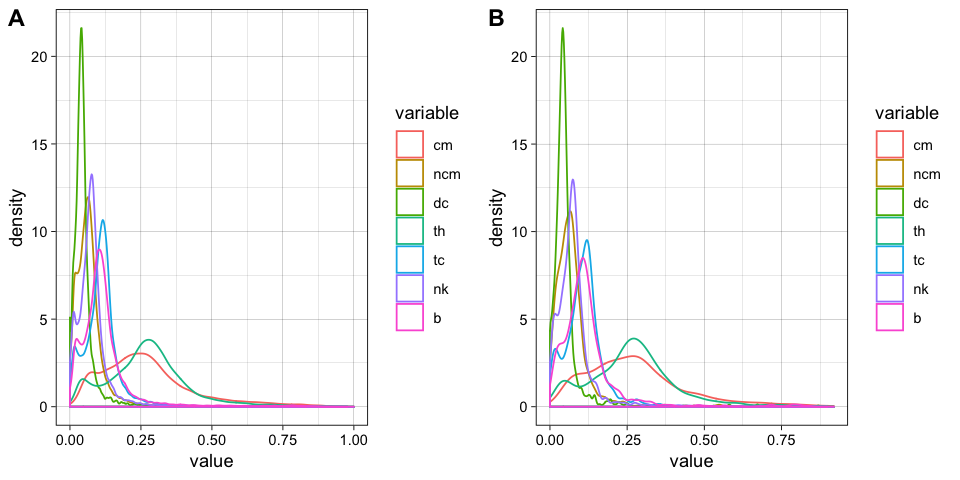

In [214]:
mat_counts_rat <- data.frame(cm=pbmc_cm_counts_rat,
                           ncm=pbmc_ncm_counts_rat,
                            dc=pbmc_dc_counts_rat,
                           th=pbmc_th_counts_rat,
                           tc=pbmc_tc_counts_rat,
                          nk=pbmc_nk_counts_rat,
                          b=pbmc_b_counts_rat)
df_counts_rat <- melt(mat_counts_rat)
ggplot1 <- ggplot(aes(value,color=variable), data=df_counts_rat)+geom_density()+theme_linedraw();

mat_counts_rat_sig <- mat_counts_rat[match(pbmc_deseq_sig,expr_gene_names),]
df_counts_rat_sig <- melt(mat_counts_rat_sig)
ggplot2 <- ggplot(aes(value,color=variable), data=df_counts_rat_sig)+geom_density()+theme_linedraw(); ##geom_histogram(alpha=0.2, position="identity")

options(repr.plot.width = 8, repr.plot.height = 4)
plot_grid(ggplot1, ggplot2, labels = "AUTO")

# Correlate cell type proportion estimate with overall expression

No id variables; using all as measure variables
No id variables; using all as measure variables


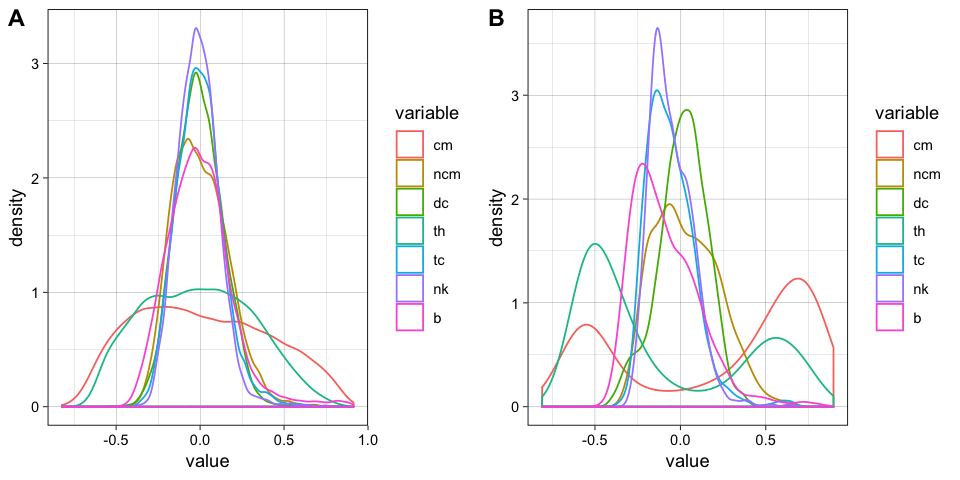

In [215]:
pbmc_cm_prop_cor <- sapply(1:nrow(pbmc_expr), function(i) {cor(pbmc_expr[i,],cm_prop,use='complete.obs')})
pbmc_th_prop_cor <- sapply(1:nrow(pbmc_expr), function(i) {cor(pbmc_expr[i,],th_prop,use='complete.obs')})
pbmc_b_prop_cor <- sapply(1:nrow(pbmc_expr), function(i) {cor(pbmc_expr[i,],b_prop,use='complete.obs')})
pbmc_nk_prop_cor <- sapply(1:nrow(pbmc_expr), function(i) {cor(pbmc_expr[i,],nk_prop,use='complete.obs')})
pbmc_ncm_prop_cor <- sapply(1:nrow(pbmc_expr), function(i) {cor(pbmc_expr[i,],ncm_prop,use='complete.obs')})
pbmc_tc_prop_cor <- sapply(1:nrow(pbmc_expr), function(i) {cor(pbmc_expr[i,],tc_prop,use='complete.obs')})
pbmc_dc_prop_cor <- sapply(1:nrow(pbmc_expr), function(i) {cor(pbmc_expr[i,],dc_prop,use='complete.obs')})

mat_prop_cor <- data.frame(cm=pbmc_cm_prop_cor,
                           ncm=pbmc_ncm_prop_cor,
                           dc=pbmc_dc_prop_cor,
                           th=pbmc_th_prop_cor,
                           tc=pbmc_tc_prop_cor,
                          nk=pbmc_nk_prop_cor,
                          b=pbmc_b_prop_cor)
df_prop_cor <- melt(mat_prop_cor)
ggplot1 = ggplot(aes(value,color=variable), data=df_prop_cor)+geom_density()+theme_linedraw(); ##geom_histogram(alpha=0.2, position="identity")

mat_prop_cor_sig <- mat_prop_cor[match(pbmc_deseq_sig,expr_gene_names),]
df_prop_cor_sig <- melt(mat_prop_cor_sig)
ggplot2 = ggplot(aes(value,color=variable), data=df_prop_cor_sig)+geom_density()+theme_linedraw(); ##geom_histogram(alpha=0.2, position="identity")

options(repr.plot.width = 8, repr.plot.height = 4)
plot_grid(ggplot1, ggplot2, labels = "AUTO")


No id variables; using all as measure variables
No id variables; using all as measure variables


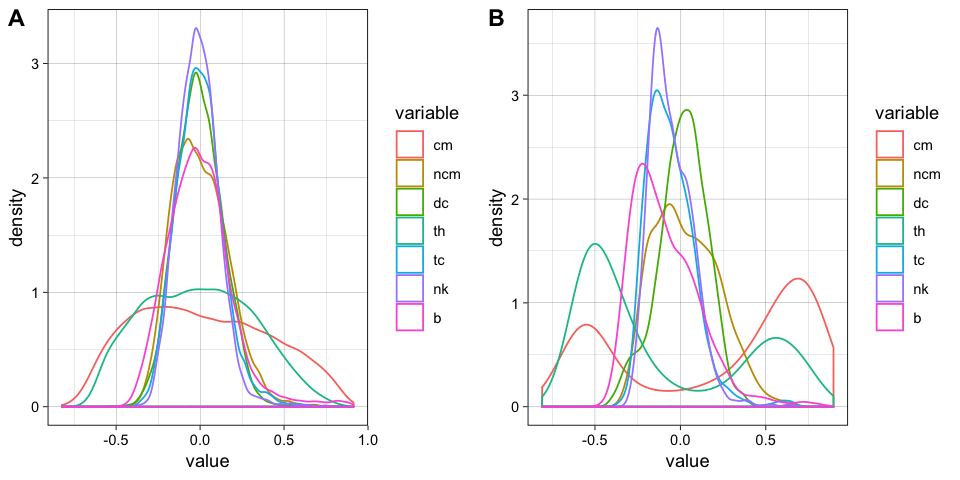

In [216]:
pbmc_std_expr <- t(apply(pbmc_expr,1,standardize));

pbmc_std_cm_prop_cor <- sapply(1:nrow(pbmc_std_expr), function(i) {cor(pbmc_std_expr[i,],cm_prop,use='complete.obs')})
pbmc_std_th_prop_cor <- sapply(1:nrow(pbmc_std_expr), function(i) {cor(pbmc_std_expr[i,],th_prop,use='complete.obs')})
pbmc_std_b_prop_cor <- sapply(1:nrow(pbmc_std_expr), function(i) {cor(pbmc_std_expr[i,],b_prop,use='complete.obs')})
pbmc_std_nk_prop_cor <- sapply(1:nrow(pbmc_std_expr), function(i) {cor(pbmc_std_expr[i,],nk_prop,use='complete.obs')})
pbmc_std_ncm_prop_cor <- sapply(1:nrow(pbmc_std_expr), function(i) {cor(pbmc_std_expr[i,],ncm_prop,use='complete.obs')})
pbmc_std_tc_prop_cor <- sapply(1:nrow(pbmc_std_expr), function(i) {cor(pbmc_std_expr[i,],tc_prop,use='complete.obs')})
pbmc_std_dc_prop_cor <- sapply(1:nrow(pbmc_std_expr), function(i) {cor(pbmc_std_expr[i,],dc_prop,use='complete.obs')})

mat_prop_cor <- data.frame(cm=pbmc_std_cm_prop_cor,
                           ncm=pbmc_std_ncm_prop_cor,
                           dc=pbmc_std_dc_prop_cor,
                           th=pbmc_std_th_prop_cor,
                           tc=pbmc_std_tc_prop_cor,
                          nk=pbmc_std_nk_prop_cor,
                          b=pbmc_std_b_prop_cor)
df_prop_cor <- melt(mat_prop_cor)
ggplot1 = ggplot(aes(value,color=variable), data=df_prop_cor)+geom_density()+theme_linedraw(); ##geom_histogram(alpha=0.2, position="identity")

mat_prop_cor_sig <- mat_prop_cor[match(pbmc_deseq_sig,expr_gene_names),]
df_prop_cor_sig <- melt(mat_prop_cor_sig)
ggplot2 = ggplot(aes(value,color=variable), data=df_prop_cor_sig)+geom_density()+theme_linedraw(); ##geom_histogram(alpha=0.2, position="identity")

options(repr.plot.width = 8, repr.plot.height = 4)
plot_grid(ggplot1, ggplot2, labels = "AUTO")


## Some sanity checking code

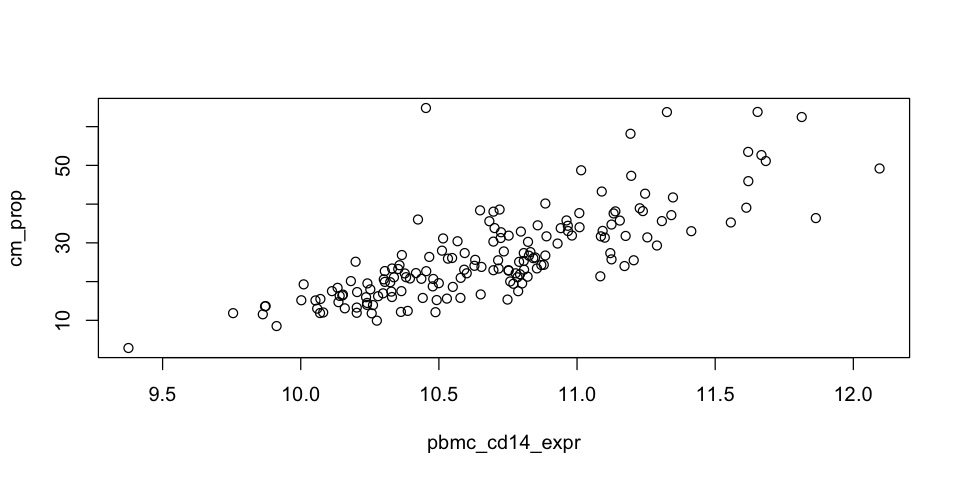

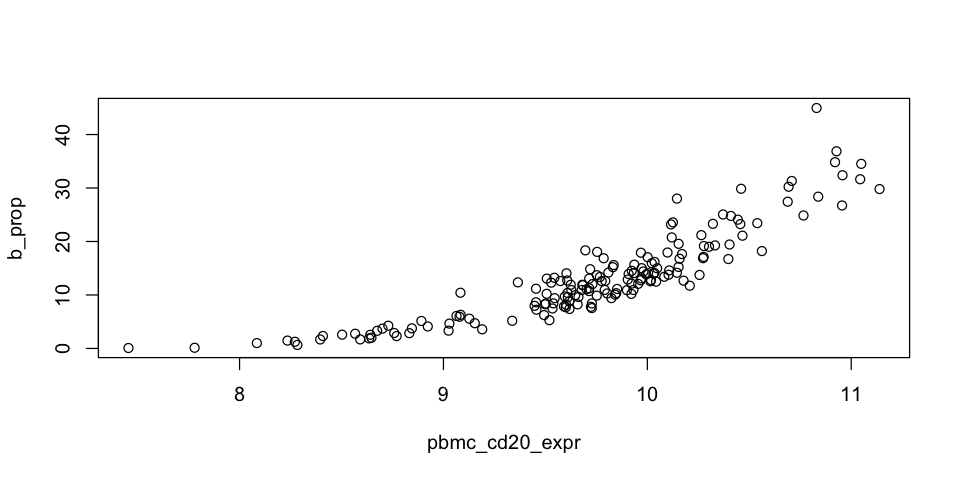

In [217]:
pbmc_cd14_expr = pbmc_expr[which(expr_gene_names=="CD14"),];
plot(pbmc_cd14_expr,cm_prop)

pbmc_cd20_expr = pbmc_expr[which(expr_gene_names=="MS4A1"),];
plot(pbmc_cd20_expr,b_prop)

In [218]:
cor(pbmc_cd14_expr, cm_prop, use='complete.obs')

[1] 0.7827447

In [219]:
counts <- fread("counts.txt",sep=",")
counts$V1 <- sapply(counts$V1, function(x) {strsplit(x,"_")[[1]][[1]]})
counts <- counts[match(colnames(pbmc_counts),counts$V1),]

In [220]:
pbmc_counts_norm <- as.matrix(sweep(pbmc_counts, 2, counts$V2, "/"))
pbmc_counts <- as.matrix(pbmc_counts) ##pbmc_counts_norm <- sapply(1:ncol(pbmc_counts), function(i) {pbmc_counts[,..i]/counts$V2[match(colnames(pbmc_counts)[i],counts$V1)]})

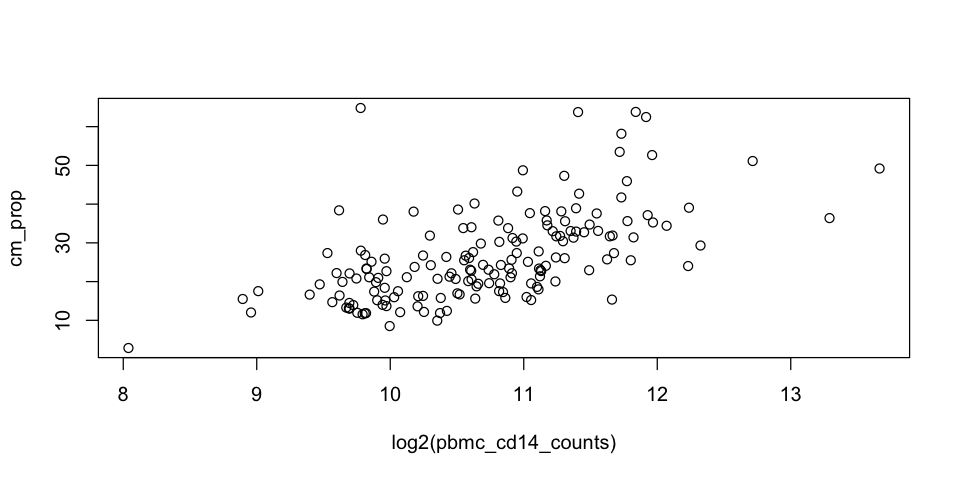

In [221]:
pbmc_cd14_counts <- pbmc_counts[which(counts_gene_names=="CD14"),match(joined_pivot_filtered$ind_cov,colnames(pbmc_counts))]
plot(log2(pbmc_cd14_counts), cm_prop)

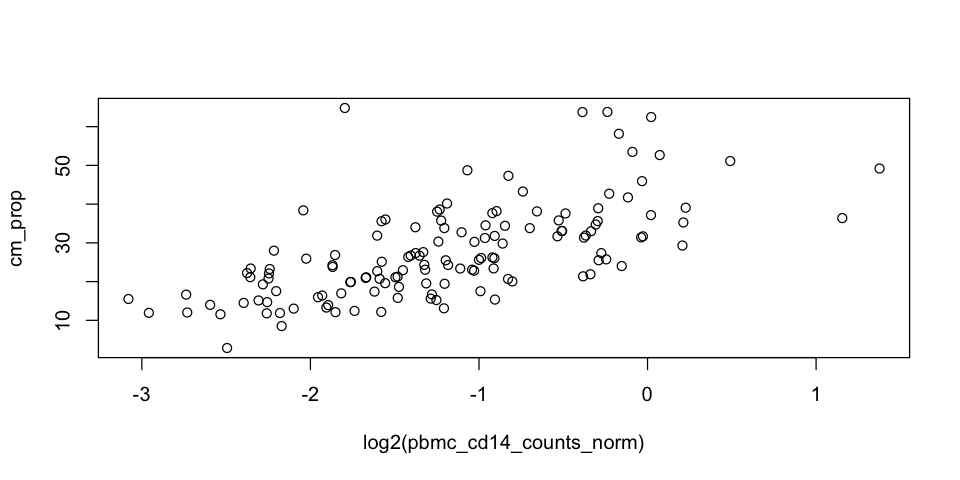

In [222]:
pbmc_cd14_counts_norm <- pbmc_counts_norm[which(counts_gene_names=="CD14"),match(joined_pivot_filtered$ind_cov,colnames(pbmc_counts))]
plot(log2(pbmc_cd14_counts_norm), cm_prop)

In [223]:
cor(log2(pbmc_cd14_counts), cm_prop,use='complete')

[1] 0.5924239

In [224]:
cor(log2(pbmc_cd14_counts_norm), cm_prop,use='complete')

[1] 0.6434284

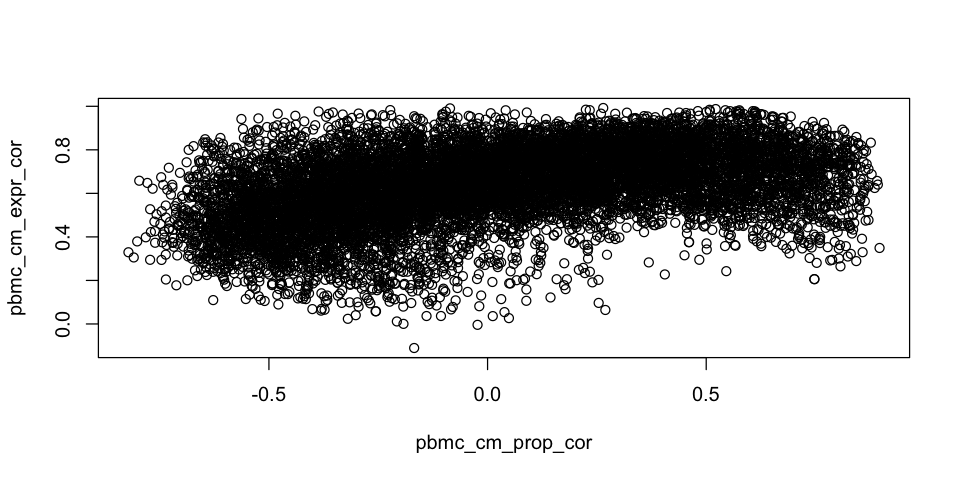

In [225]:
plot(pbmc_cm_prop_cor, pbmc_cm_expr_cor)

## Do a formal test for significance to expression and proportion

In [226]:
pbmc_cm_expr_r2 <- sapply(1:nrow(pbmc_expr), function(i) {summary(lm(pbmc_expr[i,]~cm_expr[i,]))$r.squared})
pbmc_cm_expr_p <- sapply(1:nrow(pbmc_expr), function(i) {anova(lm(pbmc_expr[i,]~cm_expr[i,]))$"Pr(>F)"}[[1]])

In [227]:
pbmc_cm_prop_r2 <- sapply(1:nrow(pbmc_expr), function(i) {summary(lm(pbmc_expr[i,]~cm_prop))$r.squared})
pbmc_cm_prop_p <- sapply(1:nrow(pbmc_expr), function(i) {anova(lm(pbmc_expr[i,]~cm_prop))$"Pr(>F)"}[[1]])

In [228]:
pbmc_cm_expr_prop_r2 <- sapply(1:nrow(pbmc_expr), function(i) {summary(lm(pbmc_expr[i,]~cm_expr[i,]+cm_prop))$r.squared})
pbmc_cm_expr_prop_p <- sapply(1:nrow(pbmc_expr), function(i) {anova(lm(pbmc_expr[i,]~cm_expr[i,]+cm_prop))$"Pr(>F)"}[[1]])

In [229]:
cm_expr_cm_prop_r2 <- sapply(1:nrow(cm_expr), function(i) {summary(lm(cm_expr[i,]~cm_prop))$r.squared})
cm_expr_cm_prop_p <- sapply(1:nrow(cm_expr), function(i) {anova(lm(cm_expr[i,]~cm_prop))$"Pr(>F)"}[[1]])

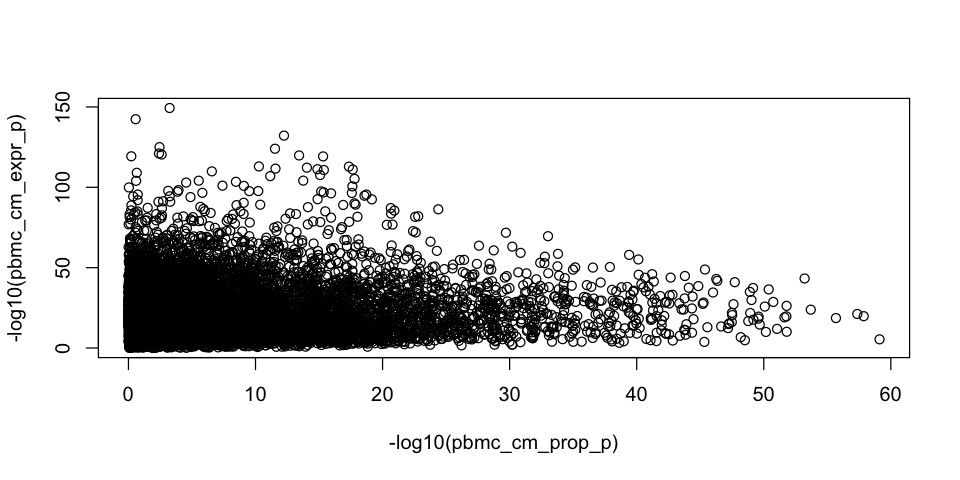

In [230]:
plot(-log10(pbmc_cm_prop_p), -log10(pbmc_cm_expr_p))
pbmc_cm_prop_sig <- which(pbmc_cm_prop_p<1e-15)
pbmc_cm_expr_sig <- which(pbmc_cm_expr_p<1e-30)
#text(-log10(cd14_prop_p)[cd14_prop_sig], -log10(cd14_expr_p)[cd14_prop_sig], labels=gene_names[cd14_prop_sig], col="red")
#text(-log10(cd14_prop_p)[cd14_expr_sig], -log10(cd14_expr_p)[cd14_expr_sig], labels=gene_names[cd14_expr_sig], col="blue")

In [231]:
pbmc_cm_total_r2 = pbmc_cm_prop_r2+pbmc_cm_expr_r2

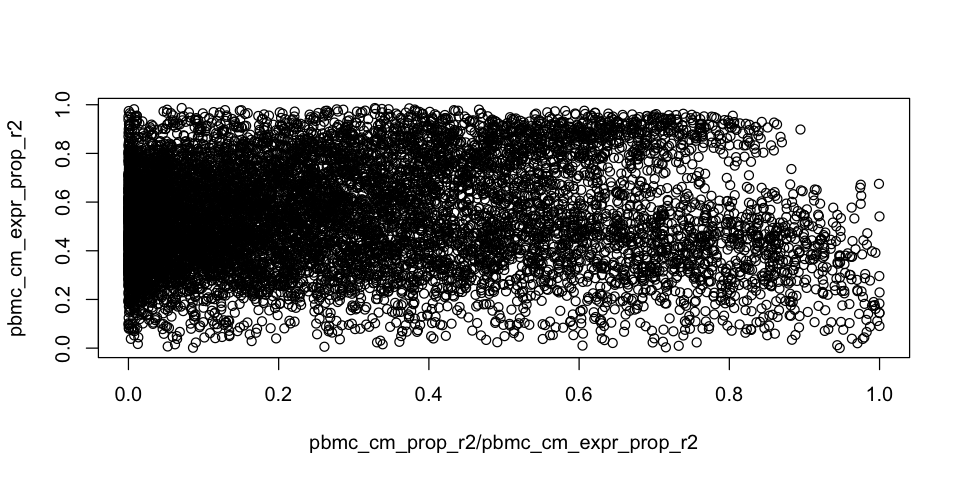

In [232]:
plot(pbmc_cm_prop_r2/pbmc_cm_expr_prop_r2, pbmc_cm_expr_prop_r2)

In [233]:
# ## let's get the batch information
# covars <- fread("/ye/yelabstore2/10x.lupus/eqtls/v2/v2.covs.csv",header=T)
# covars <- covars[,c("ind", "well", "disease", "pop", "batch")]
# covars <- covars[!duplicated(covars$ind),]
# covars$ind[grep("1891",covars$ind)] <- "1891";
# covars$ind[grep("1221",covars$ind)] <- "1221";
# covars$ind[grep("1251",covars$ind)] <- "1251";

# ifn <- fread("v2.ifn.sig.txt");
# ifn$V1[grep("1891",ifn$V1)] <- "1891";
# ifn$V1[grep("1221",ifn$V1)] <- "1221";
# ifn$V1[grep("1251",ifn$V1)] <- "1251";


# ## get clinical data
# clinical = fread("/ye/yelabstore2/10x.lupus/clinical.data/v2/v2.clinical.data.txt",header=T,sep="\t")
# clinical$genotypeid[grep("1891",clinical$genotypeid)] <- "1891";
# clinical$genotypeid[grep("1221",clinical$genotypeid)] <- "1221";
# clinical$genotypeid[grep("1251",clinical$genotypeid)] <- "1251";

# cd14.rst <- pca_cell_type_plot("CD14+.Monocytes", covars, ifn, clinical)
# pbmc.rst <- pca_cell_type_plot("PBMC", covars, ifn, clinical)
# cd4.rst <- pca_cell_type_plot("CD4.T.cells", covars, ifn, clinical)
# cd19.rst <- pca_cell_type_plot("B.cells", covars, ifn, clinical)


# # healthy <- fread("v2.healthy.PBMC.expr.matrix.eqtl.txt")
# # sle <- fread("v2.PBMC.expr.matrix.eqtl.txt")

# # gene.names <- healthy$gene;

# # all <- cbind(healthy[,-1], sle[,-1]);

# # all.log <- log2(all);
# # sle.log <- log2(sle[,-1]);
# # all.log.norm <- apply(all.log, 2, function(x) {(x-mean(x))})
# # all.log.std <- t(apply(all.log.norm, 1, function(x) {(x-mean(x))/sd(x)}))

# # all.prcomp <- prcomp(all.log.std);

# # pdf("prcomp.pdf");
# # plot(all.prcomp$rotation[,c(1,2)]);
# # dev.off();

# # sle.prcomp <- prcomp(sle.log);

# # pdf("prcomp.sle.pdf");
# # plot(sle.prcomp$rotation[,c(1,2)]);
# # dev.off();

# # healthy.cd4 <- fread("v2.healthy.CD4.T.cells.expr.matrix.eqtl.txt")
# # sle.cd4 <- fread("v2.CD4.T.cells.expr.matrix.eqtl.txt")

# # all.cd4 <- cbind(healthy.cd4[,-1], sle.cd4[,-1])

# # all.cd4.log <- log2(all.cd4);
# # sle.cd4.log <- log2(sle.cd4[,-1]);

# # all.cd4.prcomp <- prcomp(all.cd4.log[-which(is.na(rowSums(all.cd4.log))),]);


# # pdf("cd4.prcomp.pdf");
# # plot(all.cd4.prcomp$rotation[,c(1,2)]);
# # dev.off();